# OLA Driver Churn Prediction




**Column Profiling:**

1. MMMM-YY : Reporting Date (Monthly)
2. Driver\_ID : Unique id for drivers
3. Age : Age of the driver
4. Gender : Gender of the driver – Male : 0, Female: 1
5. City : City Code of the driver
6. Education\_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
7. Income : Monthly average Income of the driver
8. Date Of Joining : Joining date for the driver
9. LastWorkingDate : Last date of working for the driver
10. Joining Designation : Designation of the driver at the time of joining
11. Grade : Grade of the driver at the time of reporting
12. Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
13. Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

tenure
salary-revenue per driver
has neg business value
pct change


[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.org/github/gautamnaik1994/OLA-Driver-Churn-ML-CaseStudy/blob/main/CaseStudy.ipynb?flush_cache=true)

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as sf
from pyspark.sql.window import Window
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from pyspark.sql.types import IntegerType


import os
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
os.environ['PYSPARK_PIN_THREAD'] = 'false'

spark = SparkSession.builder \
    .appName("OLA") \
    .config("spark.sql.debug.maxToStringFields", 1000) \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.shuffle.partitions", 1) \
    .config("spark.network.timeout", "120s") \
    .config("spark.executor.heartbeatInterval", "10s") \
    .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:1.0.4,org.mlflow:mlflow-spark_2.13:2.15.1")   \
    .master("local[16]") \
    .getOrCreate();
clear_output()

In [3]:
spark.sparkContext.setLogLevel("ERROR")
cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")
spark

You are working with 1 core(s)


In [3]:
spark_df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("escape", "\"") \
    .csv("./ola_driver_scaler.csv")
spark_df.cache();

In [92]:
spark_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- MMM-YY: string (nullable = true)
 |-- Driver_ID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- City: string (nullable = true)
 |-- Education_Level: integer (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Dateofjoining: string (nullable = true)
 |-- LastWorkingDate: string (nullable = true)
 |-- Joining Designation: integer (nullable = true)
 |-- Grade: integer (nullable = true)
 |-- Total Business Value: integer (nullable = true)
 |-- Quarterly Rating: integer (nullable = true)



In [93]:
spark_df = spark_df.drop('_c0');
spark_df.show();

+--------+---------+---+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+----------------+
|  MMM-YY|Driver_ID|Age|Gender|City|Education_Level|Income|Dateofjoining|LastWorkingDate|Joining Designation|Grade|Total Business Value|Quarterly Rating|
+--------+---------+---+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+----------------+
|01/01/19|        1| 28|     0| C23|              2| 57387|     24/12/18|           NULL|                  1|    1|             2381060|               2|
|02/01/19|        1| 28|     0| C23|              2| 57387|     24/12/18|           NULL|                  1|    1|             -665480|               2|
|03/01/19|        1| 28|     0| C23|              2| 57387|     24/12/18|       03/11/19|                  1|    1|                   0|               2|
|11/01/20|        2| 31|     0|  C7|              2| 67016|     11/06/20|   

In [94]:
spark_df.select([sf.count(sf.when(sf.isnull(c), c)).alias(c) for c in spark_df.columns]).toPandas().T

,0
MMM-YY,0
Driver_ID,0
Age,61
Gender,52
City,0
Education_Level,0
Income,0
Dateofjoining,0
LastWorkingDate,17488
Joining Designation,0


<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- We can see that there are lot of missing values in the dataset for LastWorkingDate
- There are some missing values for Age and Gender

# Data Cleaning and Feature Engineering

**New features based on dates**

In [95]:
spark_df = spark_df.withColumn("reporting_month_year", sf.to_date(spark_df["MMM-YY"], "MM/dd/yy")).drop("MMM-YY")
spark_df = spark_df.withColumn("Dateofjoining", sf.to_date(spark_df["Dateofjoining"], "dd/MM/yy"))
spark_df = spark_df.withColumn("LastWorkingDate", sf.to_date(spark_df["LastWorkingDate"], "dd/MM/yy"))
spark_df = spark_df.withColumn("Quarter", sf.quarter(spark_df["reporting_month_year"]))

In [96]:
spark_df=spark_df.dropDuplicates()

In [97]:
spark_df.filter(sf.col("Gender").isNull()).show()

+---------+---+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+----------------+--------------------+-------+
|Driver_ID|Age|Gender|City|Education_Level|Income|Dateofjoining|LastWorkingDate|Joining Designation|Grade|Total Business Value|Quarterly Rating|reporting_month_year|Quarter|
+---------+---+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+----------------+--------------------+-------+
|       43| 27|  NULL| C15|              0| 12906|   2018-07-13|     2019-02-20|                  1|    1|                   0|               1|          2019-02-01|      1|
|       49| 21|  NULL| C20|              0| 53039|   2018-05-25|           NULL|                  1|    2|                   0|               1|          2019-02-01|      1|
|       49| 21|  NULL| C20|              0| 53039|   2018-05-25|           NULL|                  1|    2|              300300|   

In [98]:
spark_df.filter("Driver_ID == 305").sort("reporting_month_year").show()

+---------+----+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+----------------+--------------------+-------+
|Driver_ID| Age|Gender|City|Education_Level|Income|Dateofjoining|LastWorkingDate|Joining Designation|Grade|Total Business Value|Quarterly Rating|reporting_month_year|Quarter|
+---------+----+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+----------------+--------------------+-------+
|      305|NULL|     0|  C9|              0| 20176|   2018-08-26|           NULL|                  1|    1|                   0|               1|          2019-01-01|      1|
|      305|  24|     0|  C9|              0| 20176|   2018-08-26|     2019-08-02|                  1|    1|                   0|               1|          2019-02-01|      1|
+---------+----+------+----+---------------+------+-------------+---------------+-------------------+-----+------------------

**Null value treatment**

In [100]:
list_of_columns = ['Driver_ID',
 'Age',
 'Gender',
 'Education_Level',
 'Income',
 'Joining Designation',
 'Grade',
 'Total Business Value',
 'Quarterly Rating']

df_numpy = np.array(spark_df.select(list_of_columns).collect())

k_imputer = KNNImputer(n_neighbors=5, weights='distance')
k_imputer.fit(df_numpy)

sc = spark.sparkContext
broadcast_model = sc.broadcast(k_imputer)

column_index_mapping = {col: idx for idx, col in enumerate(list_of_columns)}

def create_knn_imputer_udf(column_name):
    index = column_index_mapping[column_name]

    @sf.udf(IntegerType())
    def knn_impute(*cols):
        row = np.array(cols).reshape(1, -1)
        imputed_row = broadcast_model.value.transform(row)
        return int(imputed_row[0][index])
    return knn_impute

In [101]:
knn_impute_Age = create_knn_imputer_udf("Age")
knn_impute_Gender = create_knn_imputer_udf("Gender")

spark_df = spark_df.withColumn("Age_Imputed", knn_impute_Age(*list_of_columns))
spark_df = spark_df.withColumn("Gender_Imputed", knn_impute_Gender(*list_of_columns))

In [102]:
spark_df = spark_df.withColumn("Age", sf.when(sf.col("Age").isNull(), sf.col("Age_Imputed")).otherwise(sf.col("Age")))
spark_df = spark_df.withColumn("Gender", sf.when(sf.col("Gender").isNull(), sf.col("Gender_Imputed")).otherwise(sf.col("Gender")))

In [103]:
spark_df = spark_df.drop("Age_Imputed", "Gender_Imputed")

**Feature Generation**

Since we want to predict whether a driver is going to churn or not, we will create a new column **<mark>&nbsp;Churned&nbsp;</mark>** as the target column

In [204]:
window_spec = Window.partitionBy("Driver_ID").orderBy("reporting_month_year")

spark_df=spark_df.withColumns({
    # "Age":  sf.coalesce(sf.col("Age"), sf.first("Age", True).over(window_spec)),
    # "Gender":  sf.coalesce(sf.col("Gender"), sf.first("Age", True).over(window_spec)),
    "LastWorkingDate":  sf.coalesce(sf.col("LastWorkingDate"), sf.first("LastWorkingDate", True).over(window_spec)),
    "Churned":  sf.when(sf.col("LastWorkingDate").isNotNull(), 1).otherwise(0),
    "Had_Negative_Business":  sf.when(sf.col("Total Business Value") > 0, 1).otherwise(0),
    "Has_Income_Increased": sf.when(sf.last("Income").over(window_spec) > sf.first("Income").over(window_spec), 1).otherwise(0),
    "Has_Rating_Increased": sf.when(sf.last("Quarterly Rating").over(window_spec) > sf.first("Quarterly Rating").over(window_spec), 1).otherwise(0),
    # "Has_Grade_Increased": sf.when(sf.last("Grade").over(window_spec) > sf.first("Grade").over(window_spec), 1).otherwise(0),
})

In [205]:
spark_df.createOrReplaceTempView("ola")

In [106]:
spark.sql(""" 
          with cte as (
            select Driver_ID, reporting_month_year, Income,
              last(Income) over(partition by Driver_ID order by reporting_month_year) - first(Income) over(partition by Driver_ID order by reporting_month_year) as diff 
            from ola 
          )
          select * from cte where diff > 0
""").show(20)

+---------+--------------------+------+-----+
|Driver_ID|reporting_month_year|Income| diff|
+---------+--------------------+------+-----+
|       26|          2020-03-01|132577|11048|
|       26|          2020-04-01|132577|11048|
|       26|          2020-05-01|132577|11048|
|       26|          2020-06-01|132577|11048|
|       26|          2020-07-01|132577|11048|
|       26|          2020-08-01|132577|11048|
|       26|          2020-09-01|132577|11048|
|       26|          2020-10-01|132577|11048|
|       26|          2020-11-01|132577|11048|
|       26|          2020-12-01|132577|11048|
|       54|          2020-06-01|127826| 9833|
|       54|          2020-07-01|127826| 9833|
|       54|          2020-08-01|127826| 9833|
|       54|          2020-09-01|127826| 9833|
|       54|          2020-10-01|127826| 9833|
|       54|          2020-11-01|127826| 9833|
|       54|          2020-12-01|127826| 9833|
|       60|          2020-07-01| 89592| 7466|
|       60|          2020-08-01| 8

In [203]:
spark.sql(""" 
          with cte as (
            select Driver_ID, reporting_month_year, Income,
              last(Grade) over(partition by Driver_ID order by reporting_month_year) - first(Grade) over(partition by Driver_ID order by reporting_month_year) as diff 
            from ola 
          )
          select distinct Driver_ID from cte where diff > 0
""").show(20)

+---------+
|Driver_ID|
+---------+
|       26|
|       54|
|       60|
|       98|
|      275|
|      307|
|      320|
|      368|
|      434|
|      537|
|      568|
|      580|
|      582|
|      638|
|      716|
|      789|
|      888|
|     1031|
|     1050|
|     1161|
+---------+
only showing top 20 rows



In [107]:
spark.sql(""" 
    select 
          Driver_Id
          , max(reporting_month_year) as max_reporting_month_year
          , max(Dateofjoining) as max_Dateofjoining
          , max(LastWorkingDate) as max_LastWorkingDate
        from ola 
        group by Driver_Id
          having max_LastWorkingDate < max_Dateofjoining
""").show()

+---------+------------------------+-----------------+-------------------+
|Driver_Id|max_reporting_month_year|max_Dateofjoining|max_LastWorkingDate|
+---------+------------------------+-----------------+-------------------+
|        5|              2019-03-01|       2019-09-01|         2019-07-03|
|       18|              2019-05-01|       2019-09-01|         2019-04-30|
|       35|              2020-05-01|       2020-07-03|         2020-05-05|
|       59|              2019-03-01|       2019-06-01|         2019-03-28|
|       82|              2020-08-01|       2020-11-04|         2020-07-29|
|      102|              2019-03-01|       2019-05-01|         2019-03-21|
|      108|              2020-06-01|       2020-09-01|         2020-02-06|
|      118|              2020-09-01|       2020-10-03|         2020-09-15|
|      121|              2020-05-01|       2020-07-03|         2020-05-24|
|      139|              2019-12-01|       2019-10-31|         2019-05-12|
|      147|              

In [108]:
spark.sql("""
          select 
          Driver_ID
          , max(`Quarterly Rating`) as max_qr
          , min(`Quarterly Rating`) as min_qr
          , avg(`Quarterly Rating`) as avg_qr 
          , count(*) as count_qr
          from ola 
          group by Driver_ID 
          order by count_qr desc
           """).show()

+---------+------+------+------+--------+
|Driver_ID|max_qr|min_qr|avg_qr|count_qr|
+---------+------+------+------+--------+
|       56|     4|     2| 2.875|      24|
|       60|     4|     2|   3.5|      24|
|      486|     3|     1| 1.875|      24|
|       63|     3|     1| 1.875|      24|
|     1472|     3|     1|  1.75|      24|
|       67|     3|     1|   2.5|      24|
|     1664|     2|     2|   2.0|      24|
|       68|     4|     3|  3.25|      24|
|     2168|     3|     2| 2.625|      24|
|       77|     4|     2|   3.0|      24|
|     2545|     3|     1|   2.0|      24|
|       78|     4|     2| 2.625|      24|
|       25|     4|     3|  3.75|      24|
|      112|     4|     2| 2.875|      24|
|      173|     4|     2|  2.75|      24|
|      115|     3|     2| 2.125|      24|
|     1612|     4|     1|  2.25|      24|
|      117|     4|     2|   2.5|      24|
|      199|     4|     2|  3.25|      24|
|      140|     3|     2| 2.625|      24|
+---------+------+------+------+--

In [110]:
spark_df.filter("`Total Business Value` = 0").limit(10).toPandas()

,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,reporting_month_year,Quarter,Churned,Had_Negative_Business,Has_Income_Increased,Has_Rating_Increased
0,1,28,0,C23,2,57387,2018-12-24,2019-11-03,1,1,0,2,2019-03-01,1,1,0,0,0
1,2,31,0,C7,2,67016,2020-06-11,None,2,2,0,1,2020-11-01,4,0,0,0,0
2,2,31,0,C7,2,67016,2020-06-11,None,2,2,0,1,2020-12-01,4,0,0,0,0
3,4,43,0,C13,2,65603,2019-07-12,None,2,2,0,1,2019-12-01,4,0,0,0,0
4,4,43,0,C13,2,65603,2019-07-12,None,2,2,0,1,2020-01-01,1,0,0,0,0
5,4,43,0,C13,2,65603,2019-07-12,None,2,2,0,1,2020-02-01,1,0,0,0,0
6,4,43,0,C13,2,65603,2019-07-12,2020-04-27,2,2,0,1,2020-04-01,2,1,0,0,0
7,5,29,0,C9,0,46368,2019-09-01,None,1,1,0,1,2019-01-01,1,0,0,0,0
8,5,29,0,C9,0,46368,2019-09-01,2019-07-03,1,1,0,1,2019-03-01,1,1,0,0,0
9,6,31,1,C11,1,78728,2020-07-31,None,3,3,0,1,2020-08-01,3,0,0,0,0


In [28]:
spark_df.select(sf.max("LastWorkingDate")).show()

+--------------------+
|max(LastWorkingDate)|
+--------------------+
|          2020-12-28|
+--------------------+



In [29]:
spark_df.select(sf.max("reporting_month_year")).show()

+-------------------------+
|max(reporting_month_year)|
+-------------------------+
|               2020-12-01|
+-------------------------+



**Data Aggregation based on Driver ID**

In [300]:
agg_map=[
    sf.first("Dateofjoining").alias("Date_Of_Joining"),
    sf.sum("Total Business Value").alias("Total_Business_Value"),
    sf.sum("Had_Negative_Business").alias("Total_Had_Negative_Business"),
    sf.max("Has_Income_Increased").alias("Has_Income_Increased"),
    sf.max("Has_Rating_Increased").alias("Has_Rating_Increased"),
    # sf.max("Has_Grade_Increased").alias("Has_Grade_Increased"),
    sf.avg("Total Business Value").cast("int").alias("Avg_Business_Value"), 
    sf.max("reporting_month_year").alias("Last_Reporting_Month"),
    sf.max("Age").alias("Age"),
    sf.mode("Gender").alias("Gender"),
    sf.last("Income").alias("Income"),
    sf.sum("Income").alias("Total_Income"),
    sf.first("Education_Level").alias("Education_Level"),
    sf.last("City").alias("City"),
    sf.first("Joining Designation").alias("Joining_Designation"),
    sf.last("Grade").alias("Grade"),
    sf.last("Quarterly Rating").alias("Quarterly_Rating"),
    # sf.min("Quarterly Rating").alias("Min_Quarterly_Rating"),
    # sf.max("Quarterly Rating").alias("Max_Quarterly_Rating"),
    sf.max("LastWorkingDate").alias("Last_Working_Date"),
    sf.max("churned").alias("Churned"),
]


merged_df = spark_df.sort("reporting_month_year").groupBy("Driver_ID").agg(*agg_map)

**Generating new features**

In [301]:

default_date = "2020-12-31"

merged_df = merged_df.withColumn(
    "Tenure",
      sf.abs(
        sf.datediff(
            sf.when(sf.col("Last_Working_Date").isNull(), sf.lit(default_date)).otherwise(sf.col("Last_Working_Date")),
            sf.col("Date_Of_Joining")
        )
    )
)


merged_df=merged_df.withColumn("Date_Of_Joining_month", sf.month(merged_df["Date_Of_Joining"]))
merged_df=merged_df.withColumn("Date_Of_Joining_year", sf.year(merged_df["Date_Of_Joining"]))
merged_df=merged_df.withColumn("Is_Valuable_Driver", sf.when(merged_df["Total_Business_Value"] > merged_df["Total_Income"], 1).otherwise(0))

merged_df.limit(5).toPandas().T

,0,1,2,3,4
Driver_ID,1,2,4,5,6
Date_Of_Joining,2018-12-24,2020-06-11,2019-07-12,2019-09-01,2020-07-31
Total_Business_Value,1715580,0,350000,120360,1265000
Total_Had_Negative_Business,1,0,1,1,1
Has_Income_Increased,0,0,0,0,0
Has_Rating_Increased,0,0,0,0,1
Avg_Business_Value,571860,0,70000,40120,253000
Last_Reporting_Month,2019-03-01,2020-12-01,2020-04-01,2019-03-01,2020-12-01
Age,28,31,43,29,31
Gender,0,0,0,0,1


In [302]:
spark_df.write.parquet("ola_driver_cleaned.parquet", mode='overwrite')
merged_df.write.parquet("ola_driver_merged.parquet", mode='overwrite')

# EDA

In [303]:
ola_df = spark.read.parquet("ola_driver_cleaned.parquet")
merged_df = spark.read.parquet("ola_driver_merged.parquet")
ola_df.createOrReplaceTempView("ola_driver")
merged_df.createOrReplaceTempView("ola_driver_merged")
ola_df=ola_df.toPandas()
merged_df=merged_df.toPandas()

In [230]:
ola_df=pd.read_parquet("ola_driver_cleaned.parquet")
merged_df=pd.read_parquet("ola_driver_merged.parquet")

In [304]:
merged_df["Last_Working_Date"] = pd.to_datetime(merged_df["Last_Working_Date"], errors="coerce")

In [305]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Driver_ID                    2381 non-null   int32         
 1   Date_Of_Joining              2381 non-null   object        
 2   Total_Business_Value         2381 non-null   int64         
 3   Total_Had_Negative_Business  2381 non-null   int64         
 4   Has_Income_Increased         2381 non-null   int32         
 5   Has_Rating_Increased         2381 non-null   int32         
 6   Avg_Business_Value           2381 non-null   int32         
 7   Last_Reporting_Month         2381 non-null   object        
 8   Age                          2381 non-null   int32         
 9   Gender                       2381 non-null   int32         
 10  Income                       2381 non-null   int32         
 11  Total_Income                 2381 non-null 

In [306]:
merged_df.describe().T

,count,mean,min,25%,50%,75%,max,std
Driver_ID,2381.0,1397.559009,1.0,695.0,1400.0,2100.0,2788.0,806.161628
Total_Business_Value,2381.0,4586741.822764,-1385530.0,0.0,817680.0,4173650.0,95331060.0,9127115.313446
Total_Had_Negative_Business,2381.0,5.231415,0.0,0.0,2.0,7.0,24.0,6.956693
Has_Income_Increased,2381.0,0.01848,0.0,0.0,0.0,0.0,1.0,0.134706
Has_Rating_Increased,2381.0,0.293574,0.0,0.0,0.0,1.0,1.0,0.455495
Avg_Business_Value,2381.0,312085.152037,-197932.0,0.0,150624.0,429498.0,3972127.0,449570.40148
Age,2381.0,33.740865,21.0,29.0,33.0,37.0,58.0,5.947781
Gender,2381.0,0.409912,0.0,0.0,0.0,1.0,1.0,0.49192
Income,2381.0,59317.239815,10747.0,39104.0,55315.0,75986.0,188418.0,28362.787012
Total_Income,2381.0,526760.305754,10883.0,139895.0,292980.0,651456.0,4522032.0,623163.278373


In [307]:
merged_df[merged_df["Tenure"]==0].T

,220,1026,1344,2041
Driver_ID,264,1207,1581,2397
Date_Of_Joining,2020-12-18,2020-12-04,2019-06-30,2020-05-15
Total_Business_Value,0,0,0,0
Total_Had_Negative_Business,0,0,0,0
Has_Income_Increased,0,0,0,0
Has_Rating_Increased,0,0,0,0
Avg_Business_Value,0,0,0,0
Last_Reporting_Month,2020-12-01,2020-04-01,2019-07-01,2020-05-01
Age,25,28,29,38
Gender,0,0,0,1


<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- We can see that there are some drivers who left on same day

## Outlier Check

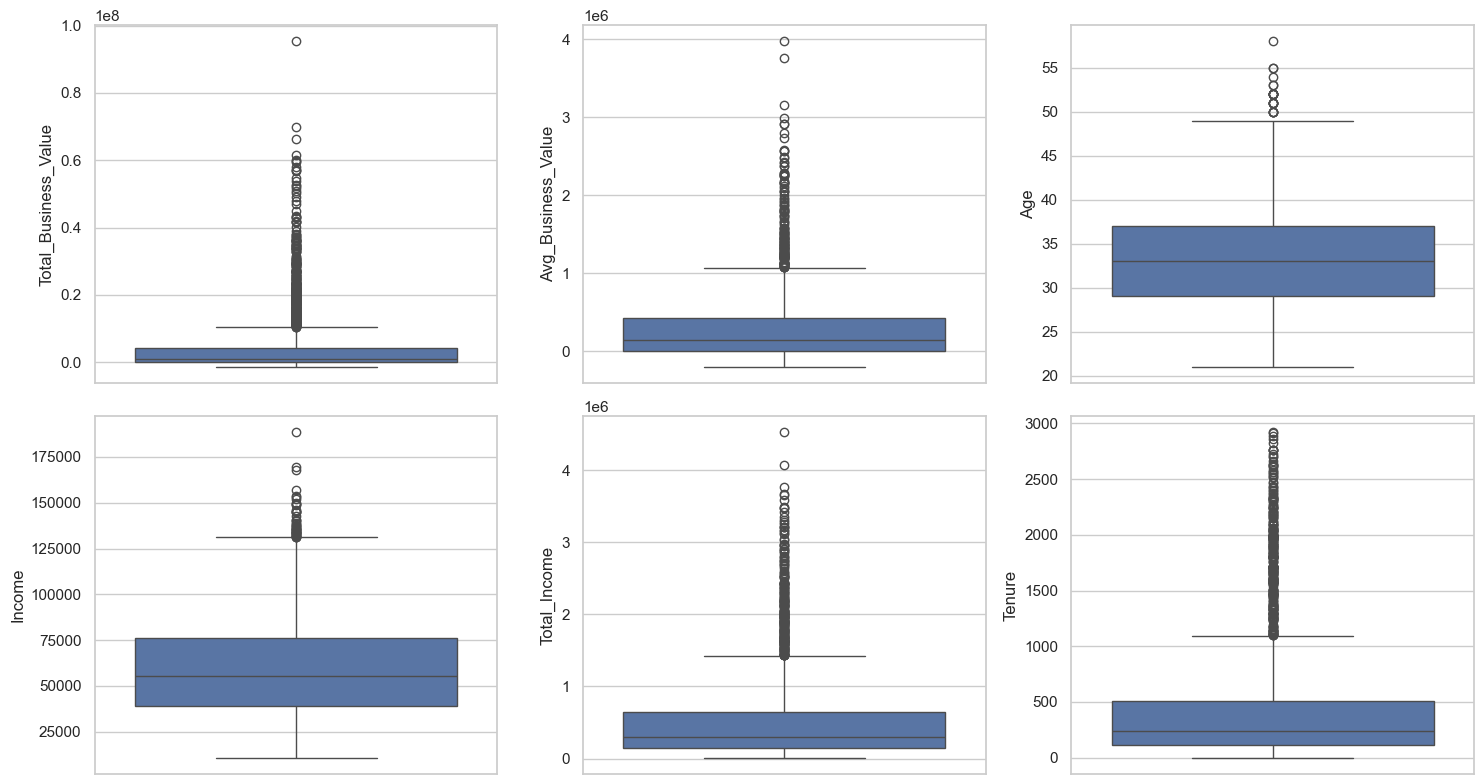

In [121]:
numerical_cols = ['Total_Business_Value', 'Avg_Business_Value', 'Age','Income', 'Total_Income', 'Tenure']

fig, ax = plt.subplots(2, 3, figsize=(15, 8))
for i, col in enumerate(numerical_cols):
    sns.boxplot(merged_df[col], ax=ax[i//3, i%3])

plt.tight_layout()

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above plot we can see there are some outliers in total business value and average business value

## Univariate Analysis

In [216]:
merged_df["Churned"].value_counts()
merged_df["Gender"].value_counts()
merged_df["Education_Level"].value_counts()
merged_df["Joining_Designation"].value_counts()
merged_df["Has_Income_Increased"].value_counts()
merged_df["Has_Rating_Increased"].value_counts()
merged_df["Is_Valuable_Driver"].value_counts()
merged_df["Has_Grade_Increased"].value_counts()

Churned
1    1616
0     765
Name: count, dtype: int64

Gender
0    1405
1     976
Name: count, dtype: int64

Education_Level
2    802
1    795
0    784
Name: count, dtype: int64

Joining_Designation
1    1026
2     815
3     493
4      36
5      11
Name: count, dtype: int64

Has_Income_Increased
0    2337
1      44
Name: count, dtype: int64

Has_Rating_Increased
0    1682
1     699
Name: count, dtype: int64

Is_Valuable_Driver
1    1526
0     855
Name: count, dtype: int64

Has_Grade_Increased
0    2337
1      44
Name: count, dtype: int64

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- In the dataset there are 1616 churned drivers
- There are 1400 male and 976 female drivers
- Almost all educations levels of drivers aew same
- Most drivers joined at 1 designation
- We can see that only 44 drivers have increased their income
- Out of all the 2381 drivers only 699 drivers has increased their rating

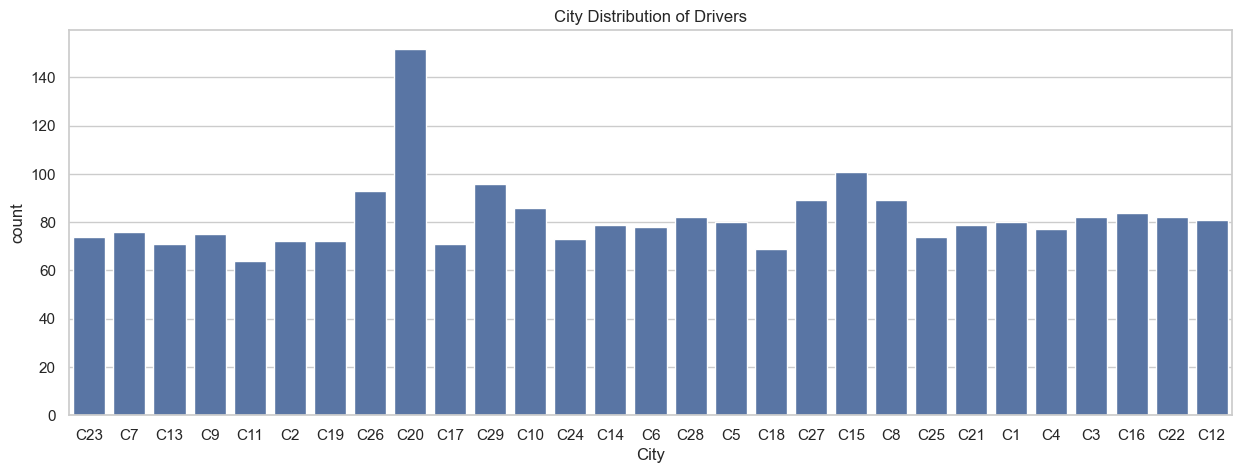

In [138]:
plt.figure(figsize=(15, 5))
sns.countplot(data=merged_df, x="City");
plt.title("City Distribution of Drivers");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- We can see that C20 has the highest number of drivers

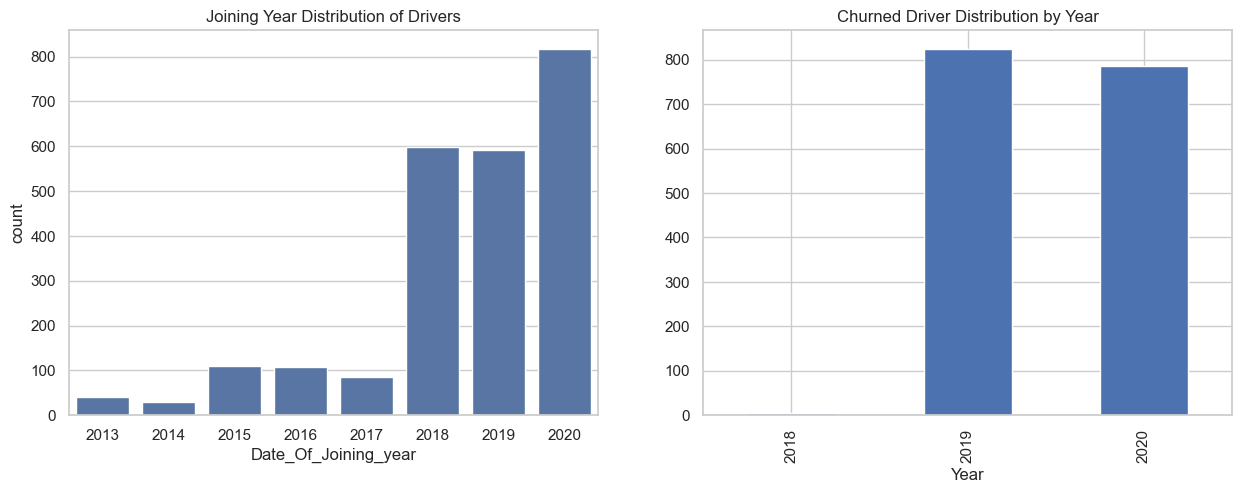

In [155]:
fig , ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x="Date_Of_Joining_year", data=merged_df, ax=ax[0]);
merged_df[merged_df["Churned"]==1]["Last_Working_Date"].dt.year.value_counts().sort_index().plot(kind="bar", ax=ax[1]);
ax[0].set_title("Joining Year Distribution of Drivers");
ax[1].set_title("Churned Driver Distribution by Year");
ax[1].set_xlabel("Year");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- We can see that there was large number of drivers who joined during 2018, and large exit of drivers during 2019

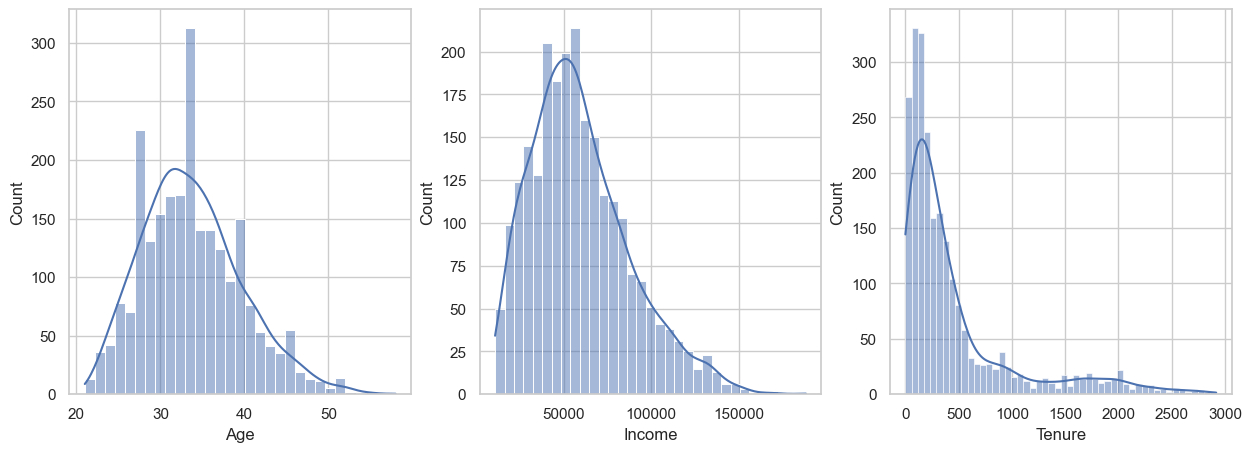

In [137]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(merged_df["Age"], kde=True, ax=ax[0])
sns.histplot(merged_df["Income"], kde=True, ax=ax[1])
sns.histplot(merged_df["Tenure"], kde=True, ax=ax[2]);

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- Above plots shows the distribution of Age, Income and Tenure.

## Bivariate Analysis

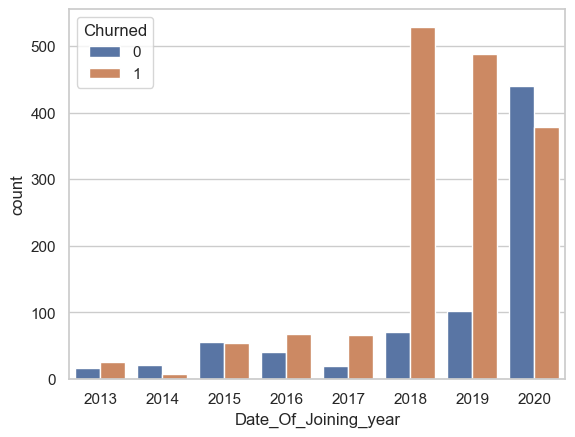

In [157]:
# fig , ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x="Date_Of_Joining_year", data=merged_df, hue="Churned");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- From plot we can see the churned and hired driver count during each year

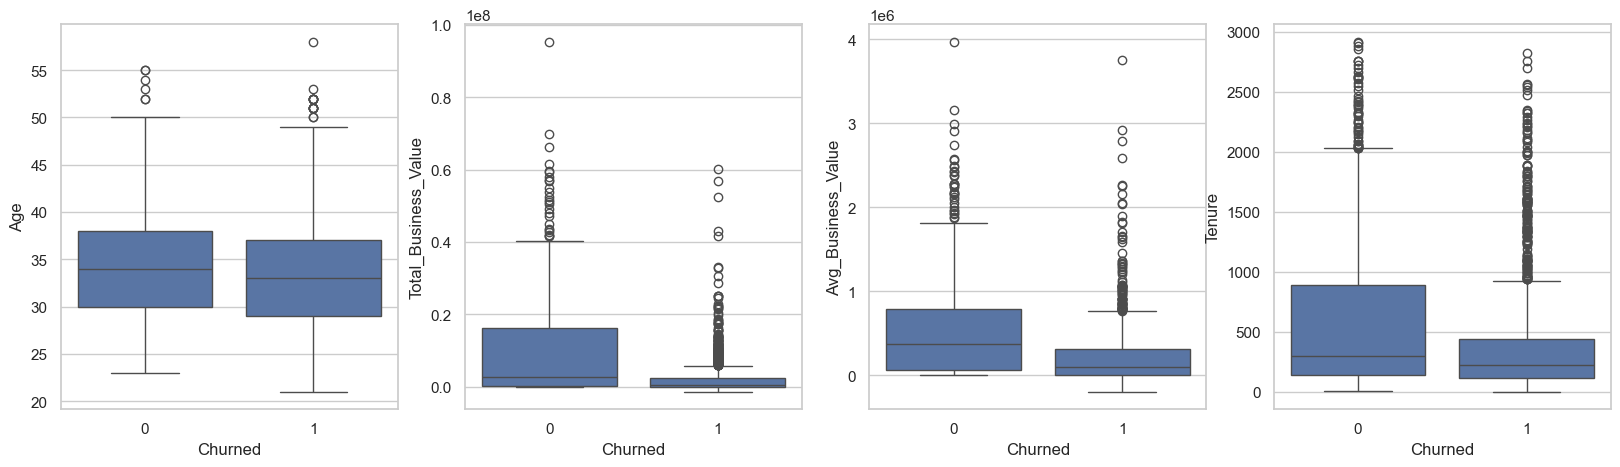

In [160]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

sns.boxplot(data=merged_df, x="Churned", y="Age", ax=ax[0]);
sns.boxplot(data=merged_df, x="Churned", y="Total_Business_Value", ax=ax[1]);
sns.boxplot(data=merged_df, x="Churned", y="Avg_Business_Value", ax=ax[2]);
sns.boxplot(data=merged_df, x="Churned", y="Tenure", ax=ax[3]);
# plt.tight_layout();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- Above plots show how different features affect the target variable
- We can see the average and total business value is less for churned drivers

In [248]:
merged_df.columns

Index(['Driver_ID', 'Date_Of_Joining', 'Total_Business_Value',
       'Total_Had_Negative_Business', 'Has_Income_Increased',
       'Has_Rating_Increased', 'Has_Grade_Increased', 'Avg_Business_Value',
       'Last_Reporting_Month', 'Age', 'Gender', 'Income', 'Total_Income',
       'Education_Level', 'City', 'Joining_Designation', 'Grade',
       'Quarterly_Rating', 'Last_Working_Date', 'Churned', 'Tenure',
       'Date_Of_Joining_month', 'Date_Of_Joining_year', 'Is_Valuable_Driver'],
      dtype='object')

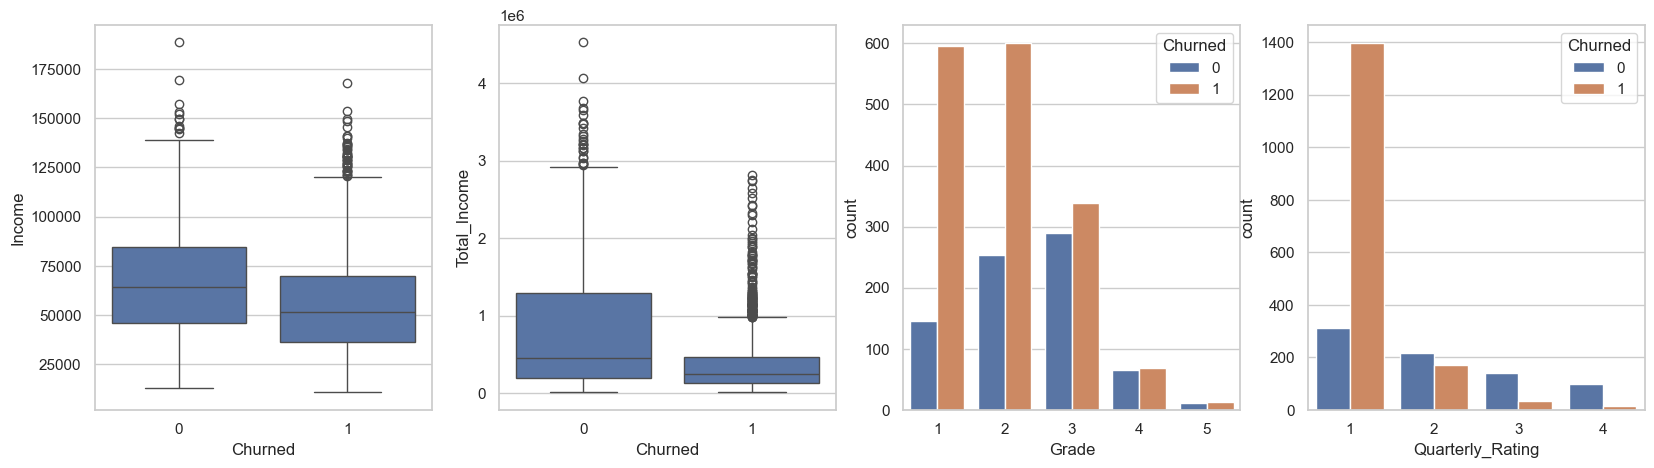

In [249]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

sns.boxplot(data=merged_df, x="Churned", y="Income", ax=ax[0]);
sns.boxplot(data=merged_df, x="Churned", y="Total_Income", ax=ax[1]);
sns.countplot(data=merged_df, x="Grade", hue="Churned", ax=ax[2]);
sns.countplot(data=merged_df, x="Quarterly_Rating", hue="Churned", ax=ax[3]);

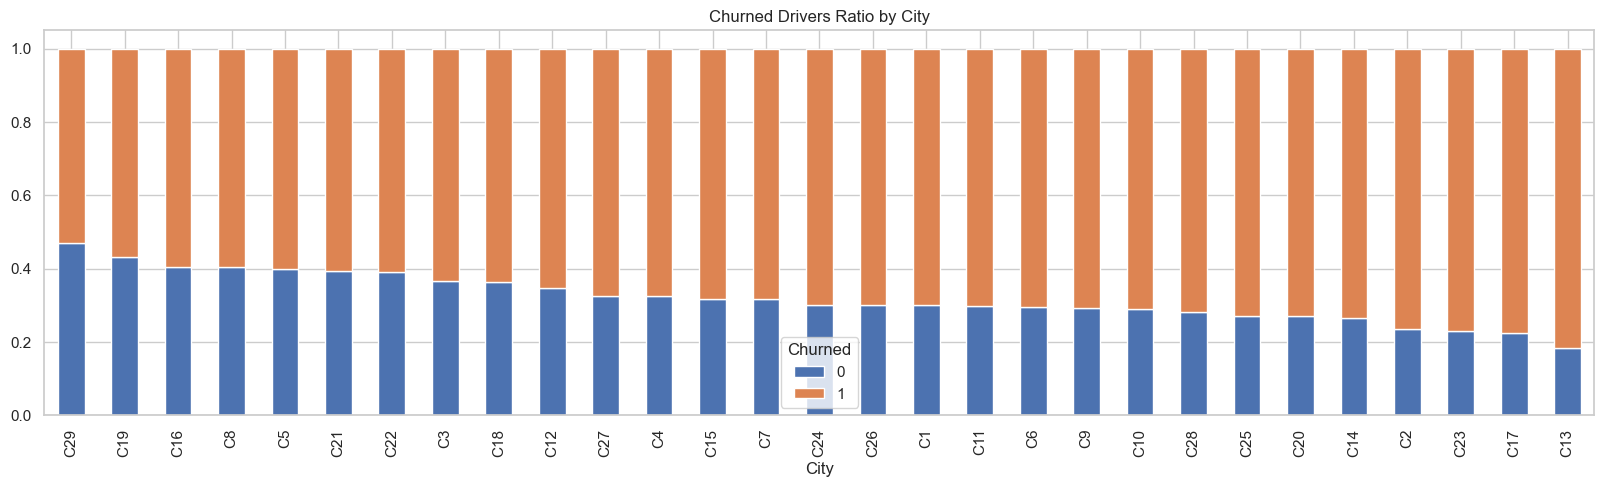

In [165]:
pd.crosstab(merged_df["City"], merged_df["Churned"],  normalize="index").sort_values(1).plot(kind="bar", stacked=True, figsize=(20, 5));
plt.title("Churned Drivers Ratio by City");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- Above plot shows the ratio of churned drivers in each city
- C13 have highest ratio of Churned drivers
- C29 have the lowest ratio of Churned drivers

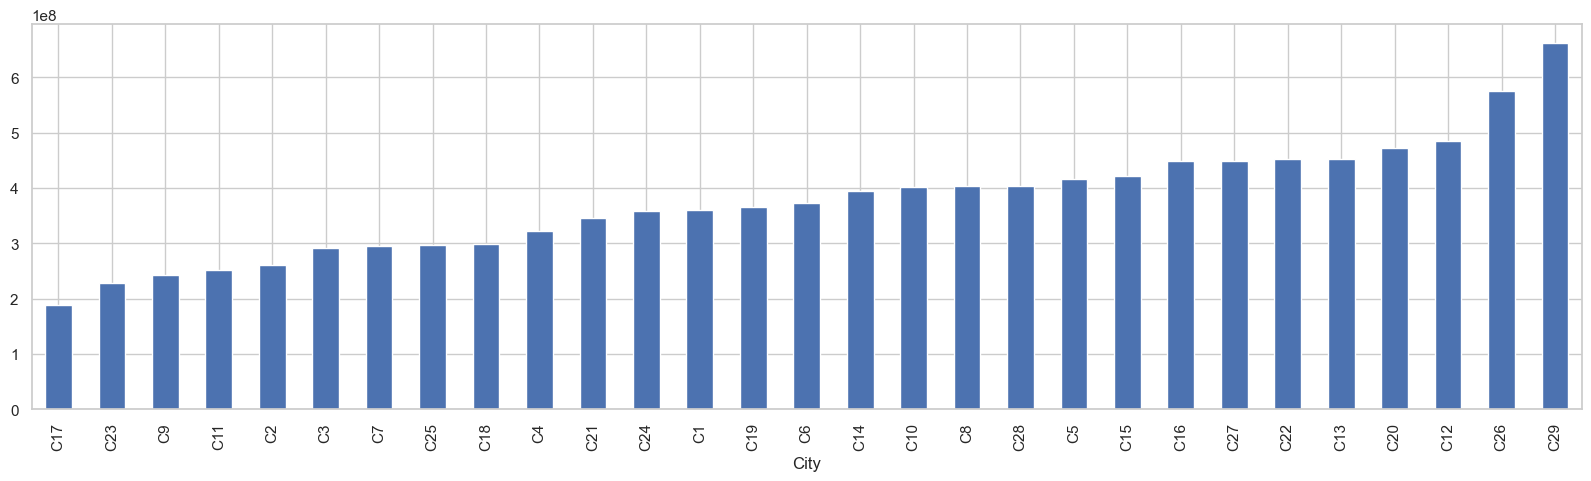

In [176]:
merged_df.groupby("City")["Total_Business_Value"].sum().sort_values().plot(kind="bar", figsize=(20, 5));

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- From above plot we can see that C29 makes the highest revenue

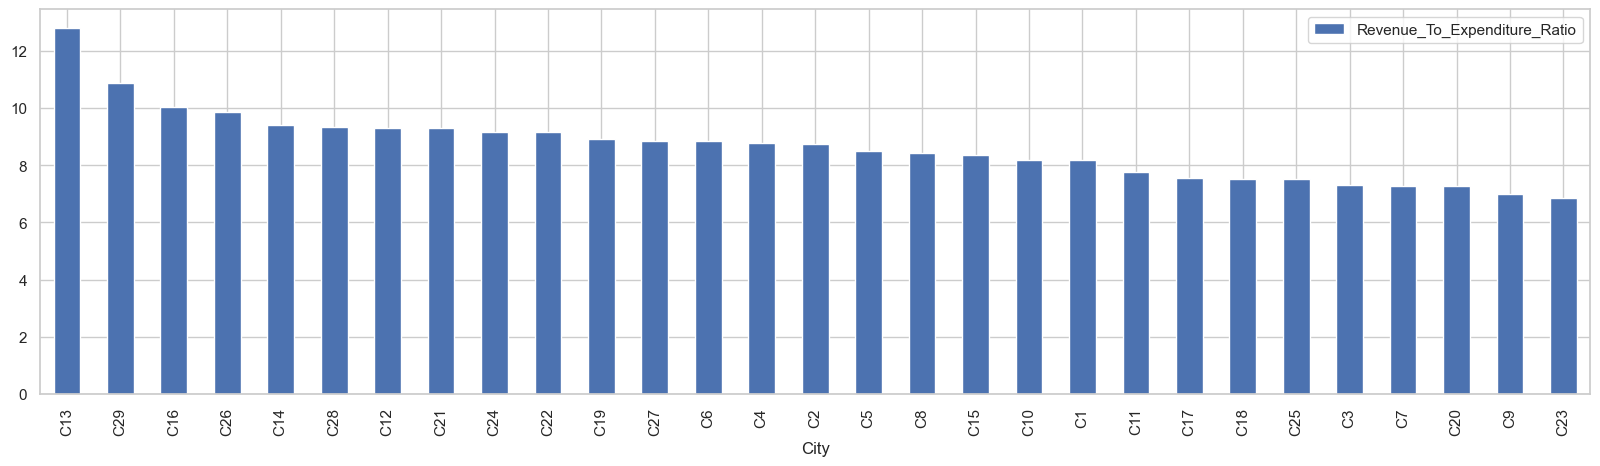

In [197]:
spark.sql("""
        select 
          City
          , round((sum(Total_Business_Value) / sum(Total_Income)),2) as Revenue_To_Expenditure_Ratio
          from ola_driver_merged
            group by City
            order by Revenue_To_Expenditure_Ratio desc
 """).toPandas().plot(kind="bar", x="City", y="Revenue_To_Expenditure_Ratio", figsize=(20, 5));

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- Above plot shows that C13 city has the best revenue to expense ratio

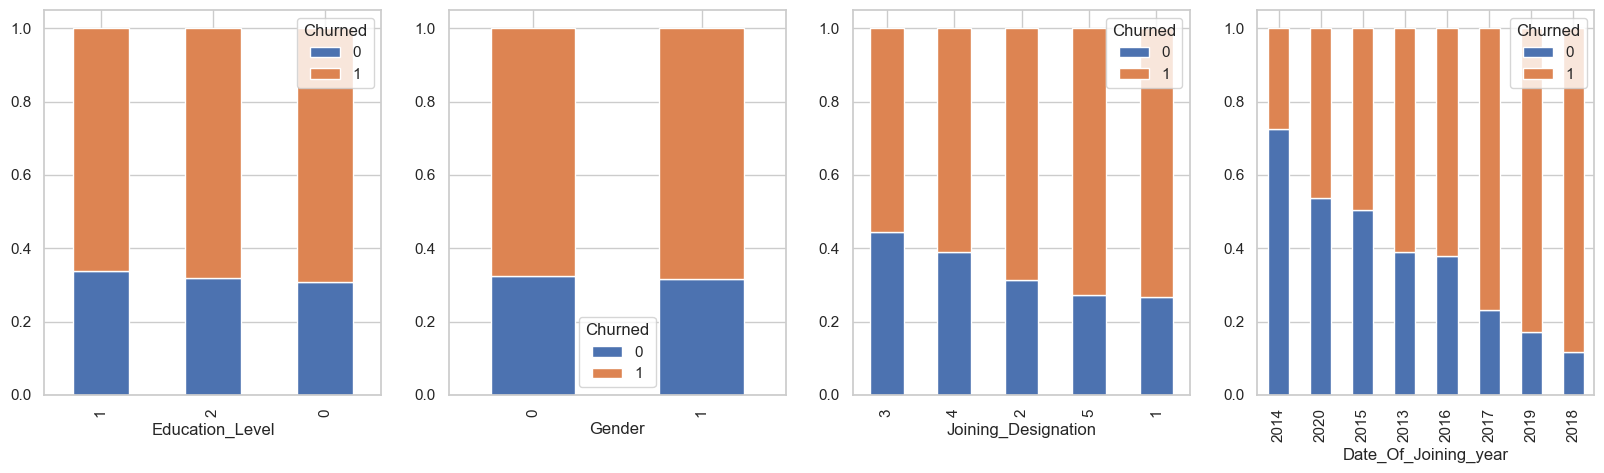

In [71]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

pd.crosstab(merged_df["Education_Level"], merged_df["Churned"],  normalize="index").sort_values(1).plot(kind="bar", stacked=True, ax=ax[0]);
pd.crosstab(merged_df["Gender"], merged_df["Churned"],  normalize="index").sort_values(1).plot(kind="bar", stacked=True, ax=ax[1]);
pd.crosstab(merged_df["Joining_Designation"], merged_df["Churned"],  normalize="index").sort_values(1).plot(kind="bar", stacked=True, ax=ax[2]);
pd.crosstab(merged_df["Date_Of_Joining_year"], merged_df["Churned"],  normalize="index").sort_values(1).plot(kind="bar", stacked=True, ax=ax[3]);

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- We can see that Gender and Education level donot have significant effect on Churn
- From above plot we can see that Joining designation and Joining year have significant effect on churn

In [250]:
merged_df.columns

Index(['Driver_ID', 'Date_Of_Joining', 'Total_Business_Value',
       'Total_Had_Negative_Business', 'Has_Income_Increased',
       'Has_Rating_Increased', 'Has_Grade_Increased', 'Avg_Business_Value',
       'Last_Reporting_Month', 'Age', 'Gender', 'Income', 'Total_Income',
       'Education_Level', 'City', 'Joining_Designation', 'Grade',
       'Quarterly_Rating', 'Last_Working_Date', 'Churned', 'Tenure',
       'Date_Of_Joining_month', 'Date_Of_Joining_year', 'Is_Valuable_Driver'],
      dtype='object')

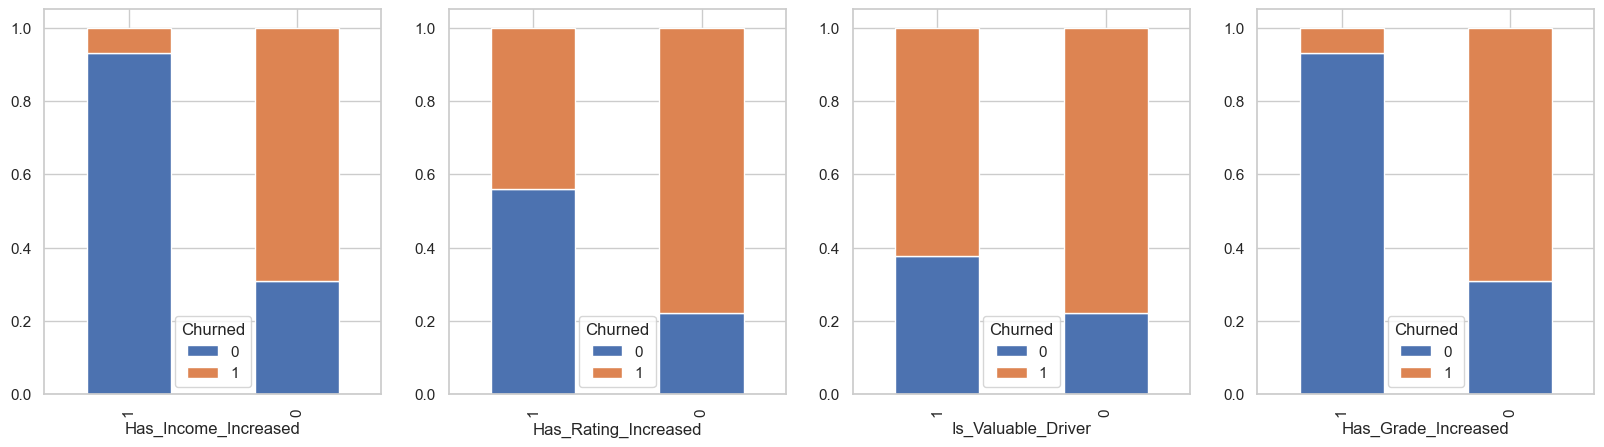

In [252]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

pd.crosstab(merged_df["Has_Income_Increased"], merged_df["Churned"],  normalize="index").sort_values(1).plot(kind="bar", stacked=True, ax=ax[0]);
pd.crosstab(merged_df["Has_Rating_Increased"], merged_df["Churned"],  normalize="index").sort_values(1).plot(kind="bar", stacked=True, ax=ax[1]);
pd.crosstab(merged_df["Is_Valuable_Driver"], merged_df["Churned"],  normalize="index").sort_values(1).plot(kind="bar", stacked=True, ax=ax[2]);
pd.crosstab(merged_df["Has_Grade_Increased"], merged_df["Churned"],  normalize="index").sort_values(1).plot(kind="bar", stacked=True, ax=ax[3]);

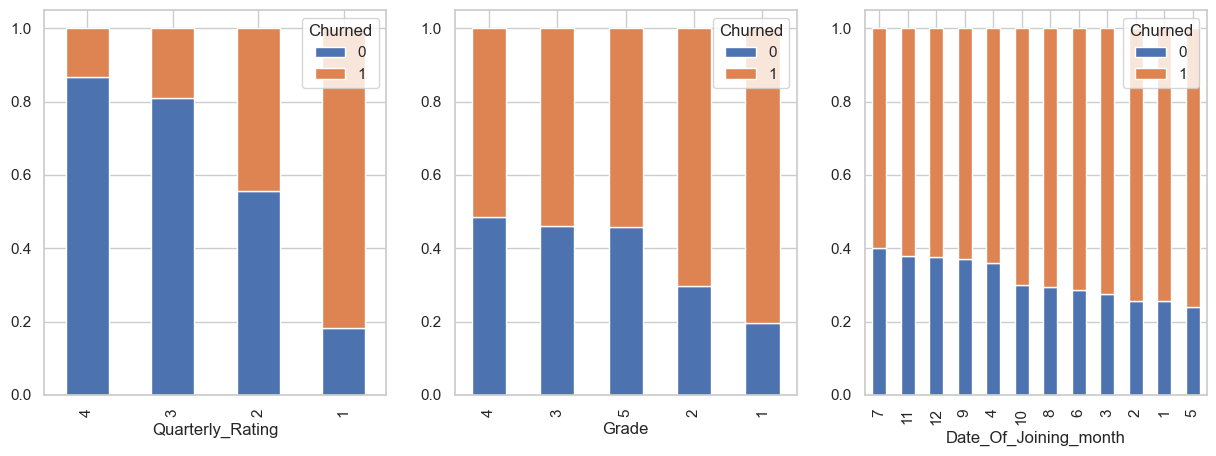

In [255]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

pd.crosstab(merged_df["Quarterly_Rating"], merged_df["Churned"],  normalize="index").sort_values(1).plot(kind="bar", stacked=True, ax=ax[0]);
pd.crosstab(merged_df["Grade"], merged_df["Churned"],  normalize="index").sort_values(1).plot(kind="bar", stacked=True, ax=ax[1]);
pd.crosstab(merged_df["Date_Of_Joining_month"], merged_df["Churned"],  normalize="index").sort_values(1).plot(kind="bar", stacked=True, ax=ax[2]);

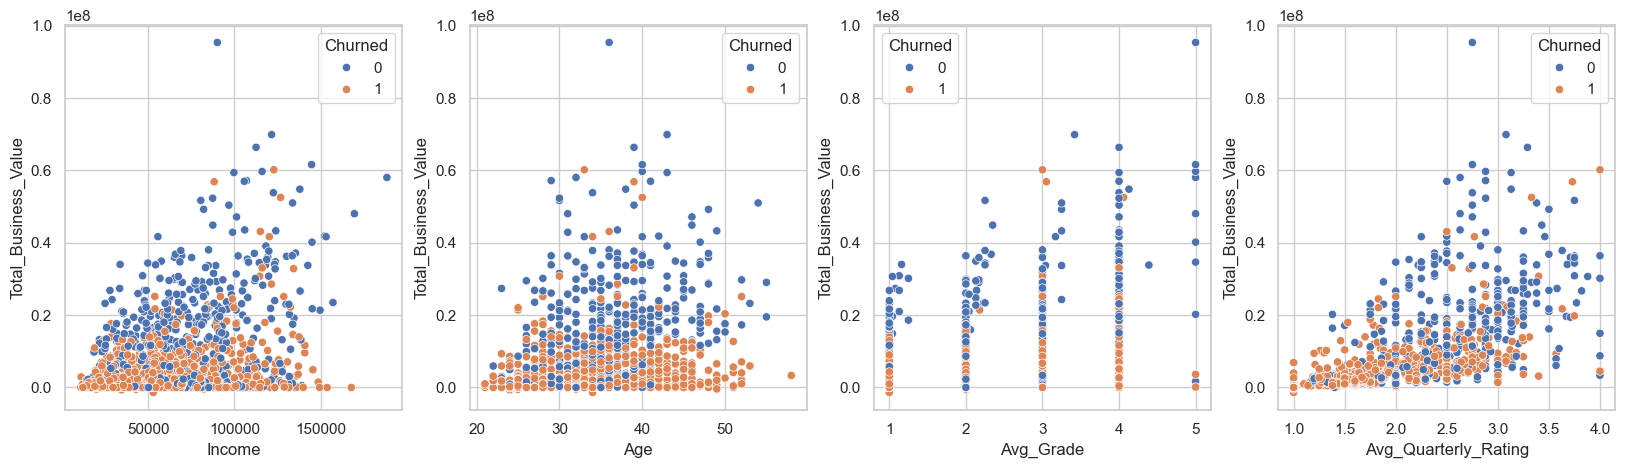

In [73]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))


sns.scatterplot(data=merged_df, x="Income", y="Total_Business_Value", hue="Churned", ax=ax[0]);
sns.scatterplot(data=merged_df, x="Age", y="Total_Business_Value", hue="Churned", ax=ax[1]);
sns.scatterplot(data=merged_df, x="Avg_Grade", y="Total_Business_Value", hue="Churned", ax=ax[2]);
sns.scatterplot(data=merged_df, x="Avg_Quarterly_Rating", y="Total_Business_Value", hue="Churned", ax=ax[3]);

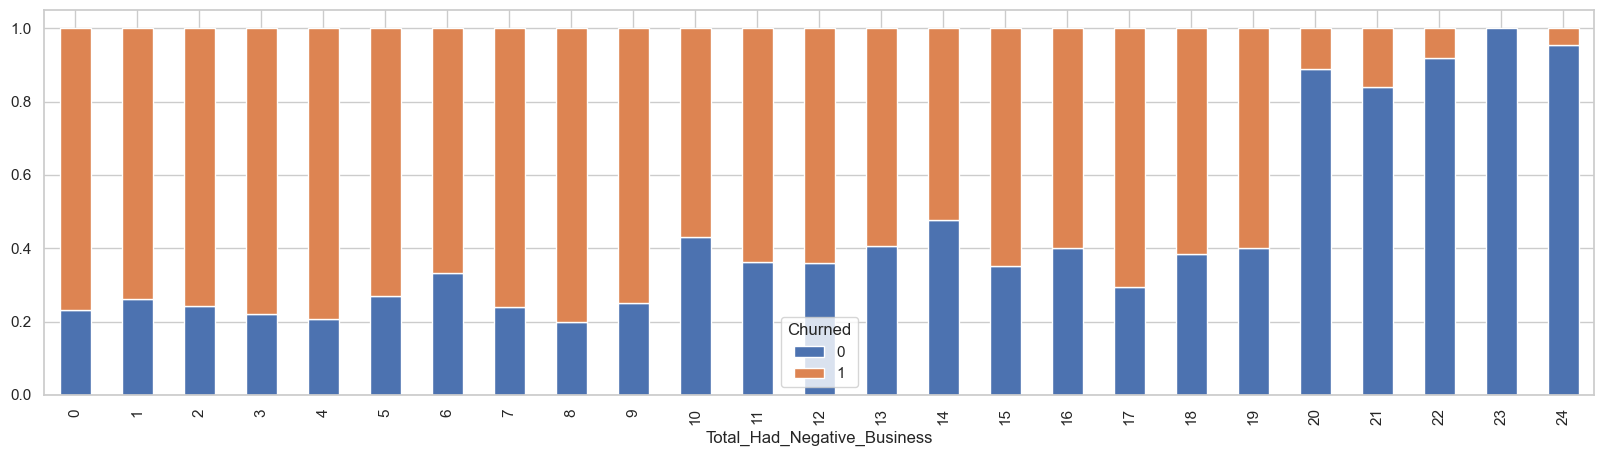

In [13]:
# sns.histplot(data=merged_df, x="Total_Had_Negative_Business", hue="Churned", kde=True);
pd.crosstab(merged_df["Total_Had_Negative_Business"], merged_df["Churned"],  normalize="index").plot(kind="bar", stacked=True, figsize=(20, 5));

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- We can see that Drivers who have negative business months are less likely to churn

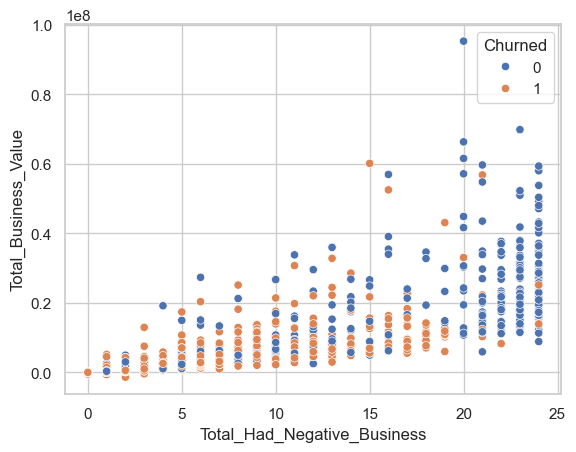

In [221]:
sns.scatterplot(data=merged_df, x="Total_Had_Negative_Business", y="Total_Business_Value", hue="Churned");

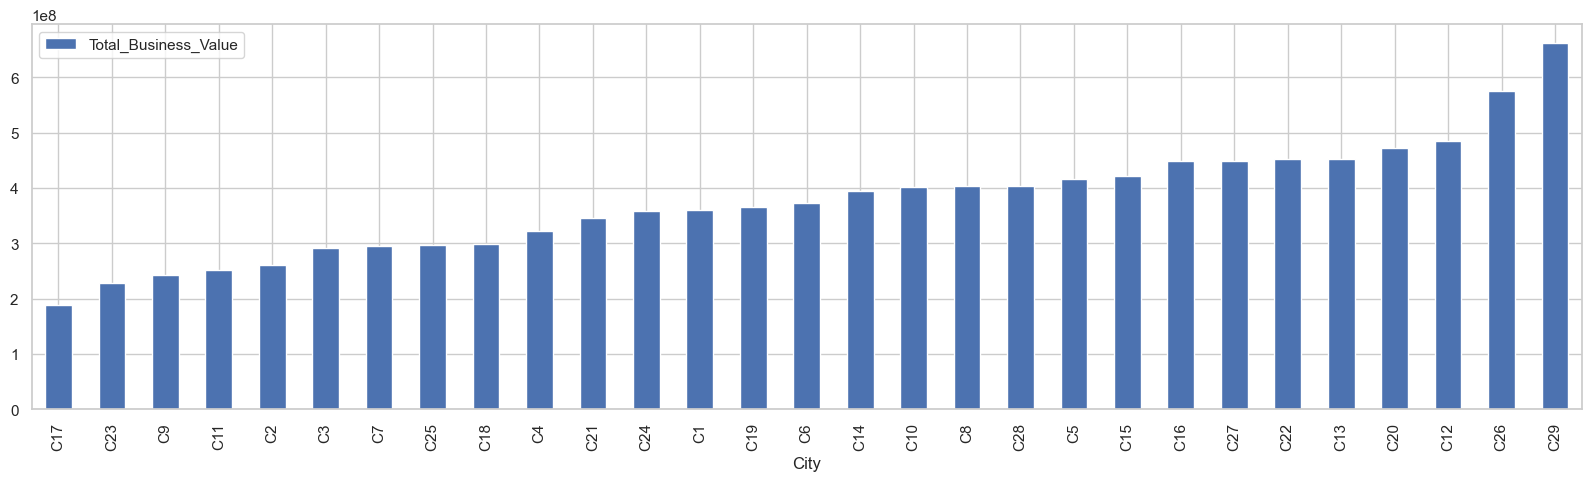

In [74]:
merged_df.groupby("City").agg({"Total_Business_Value": "sum"}).sort_values("Total_Business_Value").plot(kind="bar", figsize=(20, 5));

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- From above plot we can see that C29 city has highest revenue

In [308]:
merged_df_corr = merged_df.select_dtypes(include=[np.number]).drop("Driver_ID", axis=1).corr()

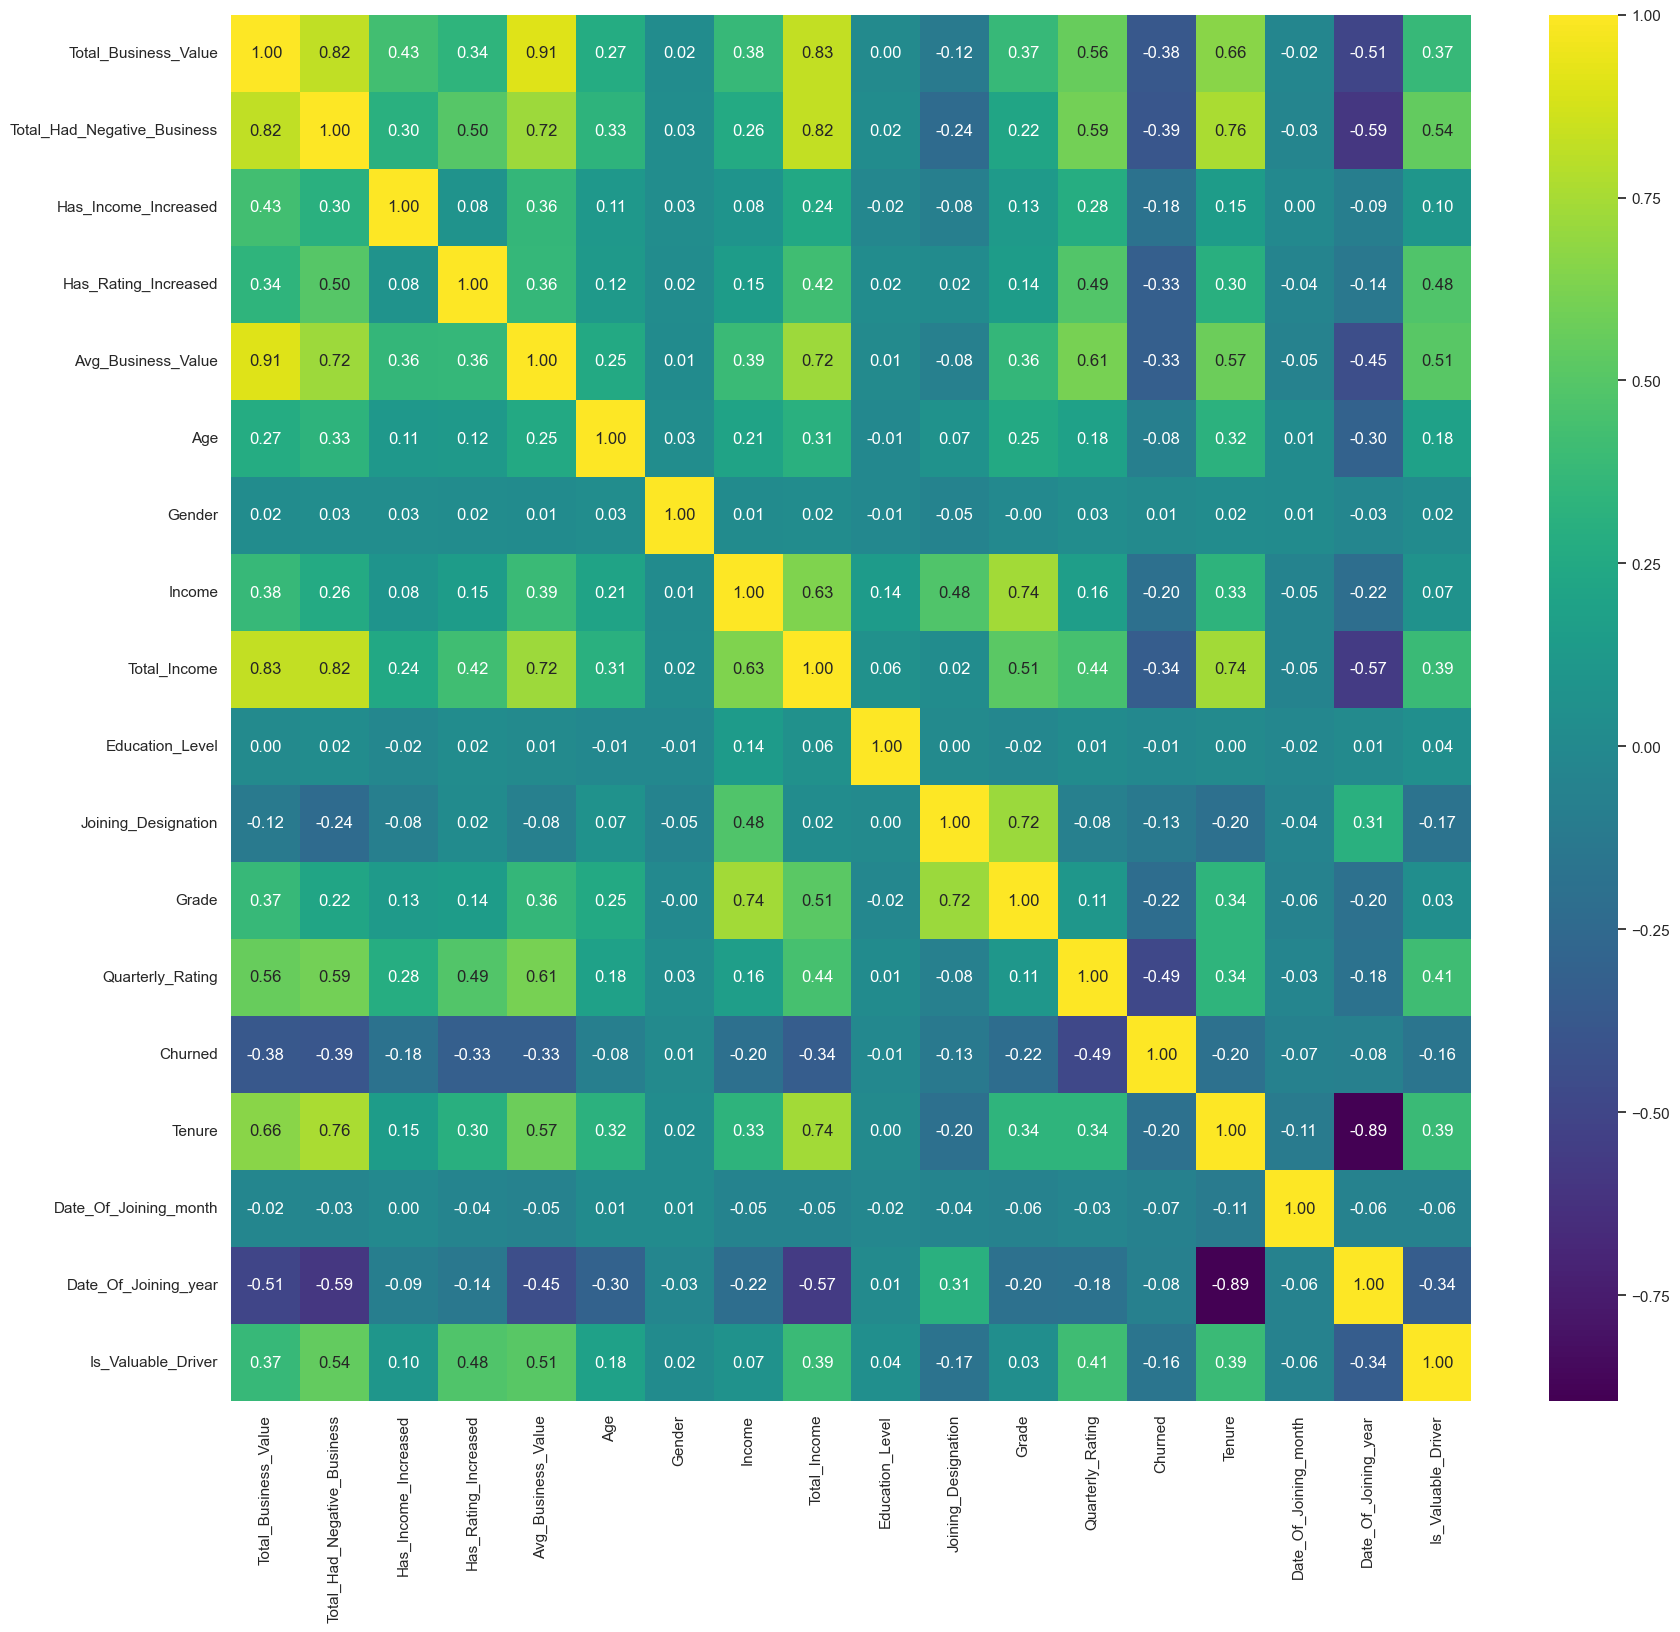

In [309]:
plt.figure(figsize=(20, 18))
sns.heatmap(merged_df_corr, annot=True, cmap="viridis", fmt=".2f");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- We can see that Tenure is correlated with Joining Year
- Average business value is correlated with total business value


# Model Building

In [4]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, RandomForestClassificationModel, GBTClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel, TrainValidationSplit, TrainValidationSplitModel
from pyspark.ml import Model
from pyspark.sql import DataFrame
from typing import Callable, Tuple
import mlflow
import mlflow.spark
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, f1_score, accuracy_score, precision_score, recall_score
from xgboost.spark import SparkXGBClassifier, SparkXGBClassifierModel

from synapse.ml.lightgbm import LightGBMClassifier, LightGBMClassificationModel

In [5]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("ola_driver_churn_v3")

mlflow.pyspark.ml.autolog(
   log_models=False,
   log_input_examples=False,
   exclusive=False,
   silent=True,
   disable=True
);

**Helper functions**

In [6]:
palette = sns.color_palette("deep", 8)  # You can choose other palettes like "deep", "muted", "bright", etc.

def print_metrics(y_true, y_pred, y_prob):
    print(classification_report(y_true, y_pred))
    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("F1 Score: ", f1_score(y_true, y_pred))
    print("AUC: ", roc_auc_score(y_true, y_prob))

def plot_confusion_matrix(y_true, y_pred, normalize='true'):
    cm = confusion_matrix(y_true, y_pred, normalize=normalize, labels=[0, 1])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, cmap="viridis", xticklabels=[0, 1], yticklabels=[0, 1]);
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual');


def plot_roc_curve(y_true, y_prob, label="Model", color='orange', show_random=True):
    fpr, tpr, threshold = roc_curve(y_true, y_prob, pos_label=1)

    if show_random:
        random_probs = [0 for i in range(len(y_true))]
        p_fpr, p_tpr, _ = roc_curve(y_true, random_probs, pos_label=1)
        plt.plot(p_fpr, p_tpr, linestyle='--', color='blue', label='Random Model')
    plt.plot(fpr, tpr, linestyle='--', color=color, label=label)
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()


def plot_precision_recall_curve(y_true, y_prob, label="Model", color='orange'):
    precision, recall, thr = precision_recall_curve(y_true,y_prob)
    plt.plot(recall, precision, color=color, label=label)

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    plt.xlabel('Recall Value')
    plt.ylabel('Precision Value')
    plt.title("PR Curve")
    plt.legend()
    
def plot_precision_recall_threshold_curve(y_true, y_prob):
    precision, recall, thr = precision_recall_curve(y_true,y_prob)
    threshold_boundary = thr.shape[0]

    plt.plot(thr, precision[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thr, recall[0:threshold_boundary], label='recall')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    plt.xlabel('Threshold Value')
    plt.ylabel('Precision Recall Value')
    plt.legend()
    plt.title("PR - Threshold Curve")
    plt.show();

def get_feature_importance(
    model: Model, 
    spark_df: DataFrame, 
    model_type: str = "pyspark"
) -> Tuple[Callable[[], None], pd.DataFrame]:
    """
    Generates a feature importance DataFrame and a lazy plot function for a given model and DataFrame.

    Parameters:
    model : pyspark.ml.Model
        The trained model from which to extract feature importances.
    spark_df : pyspark.sql.DataFrame
        The DataFrame containing the features used in the model. The DataFrame
        should have a schema with metadata that includes feature names and indices.
    model_type : str
        The type of the model ("pyspark", "lightgbm", or "xgboost").

    Returns:
    tuple
        A tuple containing:
        - plot (function): A function that, when called, generates and displays the feature importance plot.
        - pandas_df (pd.DataFrame): A Pandas DataFrame containing the feature names and their corresponding importance scores, sorted in descending order of importance.
    """

    feature_names = sorted(
        spark_df.schema["features"].metadata["ml_attr"]["attrs"]["binary"] + 
        spark_df.schema["features"].metadata["ml_attr"]["attrs"]["numeric"], 
        key=lambda x: x["idx"]
    )
    
    if model_type == "pyspark":
        importances = model.featureImportances
    elif model_type == "lightgbm":
        importances = model.getFeatureImportances()
    elif model_type == "xgboost":
        feature_imp_obj = [{"idx": int(k[1:]), "Importance": v} for k, v in model.get_feature_importances().items()]
        pandas_df = pd.DataFrame(feature_names).merge(
            pd.DataFrame(feature_imp_obj), on="idx", how="left"
        ).rename(columns={'name': "Feature"}).fillna(0).sort_values("Importance", ascending=False).drop("idx", axis=1)
        
        def plot() -> None:
            pandas_df.plot(kind="bar", x="Feature", y="Importance", figsize=(20, 5))

        return plot, pandas_df
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    feature_importance_mapping = {
        x["name"]: y for x, y in zip(feature_names, importances)
    }
    pandas_df = pd.DataFrame(
        feature_importance_mapping.items(), 
        columns=["Feature", "Importance"]
    ).sort_values("Importance", ascending=False)

    def plot() -> None:
        pandas_df.plot(kind="bar", x="Feature", y="Importance", figsize=(20, 5))

    return plot, pandas_df


def spark_prediction_to_numpy(predictions: DataFrame):
    """
    Converts Spark DataFrame predictions to NumPy arrays.

    Parameters:
    predictions : pyspark.sql.DataFrame
        The Spark DataFrame containing the columns 'prediction', 'probability', and 'Churned'.

    Returns:
    tuple
        A tuple containing:
        - y_true (np.ndarray): The true labels.
        - y_pred (np.ndarray): The predicted labels.
        - y_prob (np.ndarray): The predicted probabilities.
    """
    data = predictions.select("prediction", "probability", "Churned").collect()
    
    y_true = np.array([row['Churned'] for row in data])
    y_pred = np.array([row['prediction'] for row in data])
    y_prob = np.array([row['probability'][1] for row in data])
    
    return y_true, y_pred, y_prob



def get_all_model_params(model: CrossValidatorModel, metric="f1"):
    params = [{p.name: v for p, v in m.items()} for m in model.getEstimatorParamMaps()]

    _ = pd.DataFrame.from_dict([
        {model.getEvaluator().getMetricName(): _metric, **ps} 
        for ps, _metric in zip(params, model.avgMetrics)
    ])
    return _.sort_values(metric, ascending=False)

def get_all_model_params_tvs(model: TrainValidationSplitModel, metric="f1"):
    params = [{p.name: v for p, v in m.items()} for m in model.getEstimatorParamMaps()]

    _ = pd.DataFrame.from_dict([
        {model.getEvaluator().getMetricName(): _metric, **ps} 
        for ps, _metric in zip(params, model.validationMetrics)
    ])
    return _.sort_values(metric, ascending=False)
    

def fit_model(model, paramGrid, data, use_train_validation_split=False):
    """
    Cross validates a model using the given data and parameter grid.

    Parameters:
    model : pyspark.ml.Model
        The model to be cross-validated.
    paramGrid : pyspark.ml.tuning.ParamGridBuilder
        The parameter grid to be used for cross-validation.
    data : pyspark.sql.DataFrame
        The DataFrame containing the features and labels.
    use_train_validation_split : bool
        Whether to use TrainValidationSplit or CrossValidator.
    
    Returns:
    tuple
        A tuple containing:
        - cvModel (pyspark.ml.Model): The cross-validated model.
        - evaluator (pyspark.ml.evaluation.Evaluator): The evaluator used for cross-validation.
    """
    evaluator = MulticlassClassificationEvaluator(labelCol="Churned", predictionCol="prediction", metricName="f1", weightCol='classWeightCol')

    if use_train_validation_split:
        _model = TrainValidationSplit(estimator=model,
                            estimatorParamMaps=paramGrid,
                            evaluator=evaluator,
                            parallelism=16, 
                            # collectSubModels=True,
                            trainRatio = 0.8,
                            seed=42)
    else:
        _model = CrossValidator(estimator=model,
                            estimatorParamMaps=paramGrid,
                            evaluator=evaluator,
                            numFolds=3,
                            parallelism=16, 
                            # collectSubModels=True,
                            seed=42)
    cvModel = _model.fit(data)
    return cvModel, evaluator

# def get_best_threshold(y_true, y_prob):
#     fpr, tpr, thresholds = roc_curve(y_true, y_prob, pos_label=1)
#     gmeans = np.sqrt(tpr * (1-fpr))
#     ix = np.argmax(gmeans)
#     return thresholds[ix]

def get_best_threshold(y_true, y_prob):
    thresholds = np.arange(0.0, 1.0, 0.01)

    precisions = []
    recalls = []
    f1s = []

    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        precisions.append(precision_score(y_true, y_pred))
        recalls.append(recall_score(y_true, y_pred))
        f1s.append(f1_score(y_true, y_pred))
        
    best_threshold = thresholds[np.argmax(f1s)]

    print(f'Best threshold: {best_threshold}')
    print(f'Precision at best threshold: {precisions[np.argmax(f1s)]}')
    print(f'Recall at best threshold: {recalls[np.argmax(f1s)]}')
    print(f'F1 score at best threshold: {f1s[np.argmax(f1s)]}')
    return best_threshold

## Preprocessing

In [7]:
model_df = spark.read.parquet("ola_driver_merged.parquet")
model_df.cache();

In [8]:
model_df.limit(3).toPandas().T

,0,1,2
Driver_ID,1,2,4
Date_Of_Joining,2018-12-24,2020-06-11,2019-07-12
Total_Business_Value,1715580,0,350000
Total_Had_Negative_Business,1,0,1
Has_Income_Increased,0,0,0
Has_Rating_Increased,0,0,0
Avg_Business_Value,571860,0,70000
Last_Reporting_Month,2019-03-01,2020-12-01,2020-04-01
Age,28,31,43
Gender,0,0,0


**Categorical and OneHot Encoding**

In [10]:
categorical_columns = ["City"]
indexers = [StringIndexer(inputCol=column, outputCol=column + "Index")
            for column in categorical_columns]

for indexer in indexers:
    model_df = indexer.fit(model_df).transform(model_df)
    encoder = OneHotEncoder(inputCol=indexer.getOutputCol(),
                            outputCol=indexer.getInputCol() + "_Vec")
    model_df = encoder.fit(model_df).transform(model_df)

feature_columns = [
    'Total_Business_Value',
    'Total_Had_Negative_Business',
    'Has_Income_Increased',
    'Has_Rating_Increased',
    'Avg_Business_Value',
    'Age',
    'Gender',
    'Income',
    'Total_Income',
    'Education_Level',
    'City_Vec',
    'Joining_Designation',
    'Grade',
    'Quarterly_Rating',
    'Tenure',
    'Date_Of_Joining_month',
    'Date_Of_Joining_year',
    'Is_Valuable_Driver'
]

to_drop = ["Driver_ID", "Date_Of_Joining",
           "Last_Working_Date", "Last_Reporting_Month", "CityIndex"]
model_df = model_df.drop(*to_drop)

**Vectorization**

In [11]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
model_df = assembler.transform(model_df)
class_weights = model_df.groupBy("Churned").count().collect()
total_count = model_df.count()
weights = {row['Churned']: total_count / row['count'] for row in class_weights}
model_df = model_df.withColumn("classWeightCol", sf.when(model_df["Churned"] == 1, weights[1]).otherwise(weights[0]))


**Train Test Validation Split**

In [12]:
(trainingData, testData) = model_df.randomSplit([0.8, 0.2], seed=42)

sc = StandardScaler(inputCol="features", outputCol="sc_features")
sc_model = sc.fit(trainingData)
trainingData = sc_model.transform(trainingData)
testData = sc_model.transform(testData)

trainingData_v2, validationData = trainingData.randomSplit([0.8, 0.2], seed=42)

In [12]:
trainingData.write.parquet("ola_driver_training.parquet", mode='overwrite')
testData.write.parquet("ola_driver_test.parquet", mode='overwrite')
validationData.write.parquet("ola_driver_validation.parquet", mode='overwrite')
trainingData_v2.write.parquet("ola_driver_training_v2.parquet", mode='overwrite')

In [9]:
trainingData = spark.read.parquet("ola_driver_training.parquet")
testData = spark.read.parquet("ola_driver_test.parquet")
validationData = spark.read.parquet("ola_driver_validation.parquet")
trainingData_v2 = spark.read.parquet("ola_driver_training_v2.parquet")
trainingData.cache()
testData.cache()
validationData.cache()
trainingData_v2.cache();

## Random Forest

**Hyperparamenter Tuning using Grid Search and Cross Validation**

In [15]:
rf = RandomForestClassifier(labelCol="Churned", featuresCol="features", weightCol="classWeightCol", seed=42)
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [200, 250, 300, 350]).addGrid(rf.maxDepth, [5, 10, 15, 20]).build()

with mlflow.start_run(run_name="Random Forest" ):
    rf_cv_model, rf_evaluator = fit_model(rf, paramGrid, trainingData)
    mlflow.log_params({
        "best_numTrees": rf_cv_model.bestModel.getNumTrees,
        "best_maxDepth": rf_cv_model.bestModel.getMaxDepth()
    })
    test_predictions = rf_cv_model.bestModel.transform(testData)

    mlflow.log_metrics({
        "best_f1": rf_evaluator.evaluate(test_predictions),
        "best_accuracy": rf_evaluator.setMetricName("accuracy").evaluate(test_predictions),
        "best_precision": rf_evaluator.setMetricName("weightedPrecision").evaluate(test_predictions),
        "best_recall": rf_evaluator.setMetricName("weightedRecall").evaluate(test_predictions)
    })

**Get the best model**

In [16]:
best_rf = rf_cv_model.bestModel
print("NumTrees: ", best_rf.getNumTrees, "MaxDepth: ", best_rf.getMaxDepth())
best_rf.write().overwrite().save("./model/rf_model")

NumTrees:  250 MaxDepth:  10


In [1]:
best_rf = RandomForestClassificationModel.load("./model/rf_model")
print("NumTrees: ", best_rf.getNumTrees, "MaxDepth: ", best_rf.getMaxDepth());

**Feature Importance**

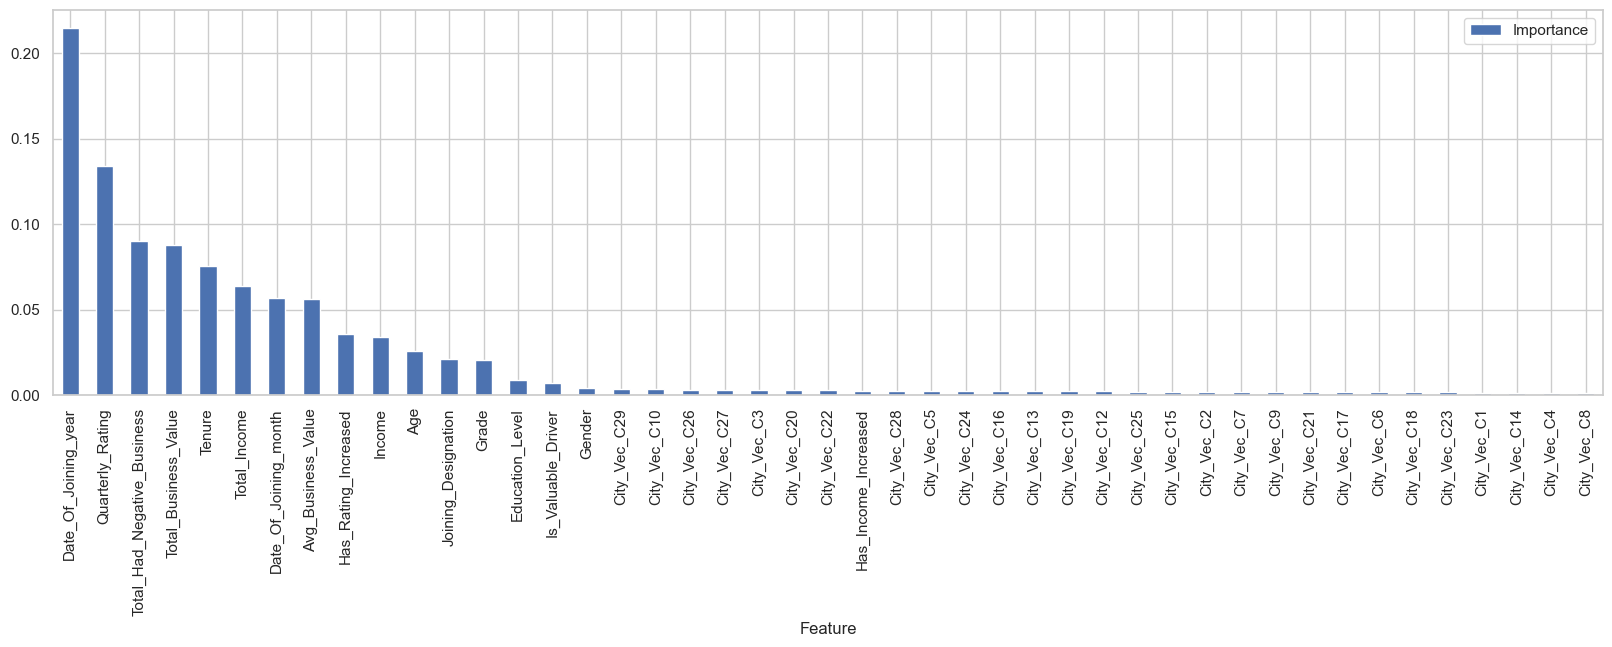

In [19]:
plot_func, _= get_feature_importance(best_rf, model_df, model_type="pyspark")
plot_func();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- We can see that Joining year is the most important feature followed by Quaterly rating

### Metrics

In [ ]:
test_predictions = best_rf.transform(testData)

In [20]:
y_true, y_pred, y_prob = spark_prediction_to_numpy(test_predictions);

**Classification Report**

In [21]:
print_metrics(y_true, y_pred, y_prob)

              precision    recall  f1-score   support

           0       0.81      0.82      0.82       154
           1       0.90      0.89      0.89       263

    accuracy                           0.86       417
   macro avg       0.85      0.86      0.85       417
weighted avg       0.86      0.86      0.86       417

Accuracy:  0.8633093525179856
F1 Score:  0.8910133843212237
AUC:  0.9364969631129327


In [22]:
best_threshold= get_best_threshold(y_true, y_prob)

Best threshold: 0.4
Precision at best threshold: 0.872791519434629
Recall at best threshold: 0.9391634980988594
F1 score at best threshold: 0.9047619047619048


In [23]:
y_pred = (y_prob >= best_threshold).astype(int)

**Best F1 score adjusted Classification Report**

In [24]:
print_metrics(y_true, y_pred, y_prob)

              precision    recall  f1-score   support

           0       0.88      0.77      0.82       154
           1       0.87      0.94      0.90       263

    accuracy                           0.88       417
   macro avg       0.88      0.85      0.86       417
weighted avg       0.88      0.88      0.87       417

Accuracy:  0.8752997601918465
F1 Score:  0.9047619047619048
AUC:  0.9364969631129327


<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- With these new adjustment the, the f1 score increased by 1%, recall by 5% but precision is decreased by 3%

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #9C27B0;color: #fff;display: inline-block;'>Insights</b>
- A Recall of 94% means that out of all churned drivers, the model was correct 94% of times
- A precision of 87% means that out of all churned drivers predicted, 87% were actually churned.

**PR vs Threshold Curve**

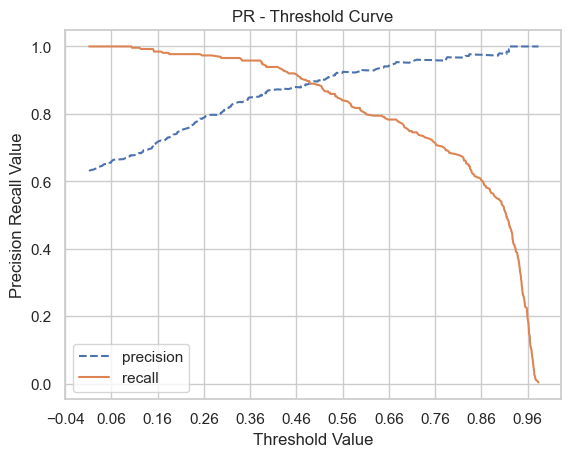

In [25]:
plot_precision_recall_threshold_curve(y_true, y_prob)

<b style='padding: 4px 10px 6px 10px;border-radius: 6px;background: #009688; color: #fff;display: inline-block;'>Observations</b>

- From above plot we can decide on optimal value of threshold as that can maximize precision or recall as per business needs

**Precision Recall Curve**

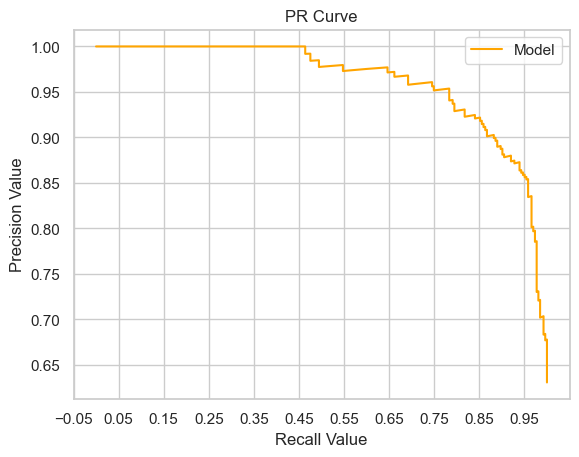

In [26]:
plot_precision_recall_curve(y_true, y_prob)

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- Above plot illustrates the tradeoff between precision and recall value of the model

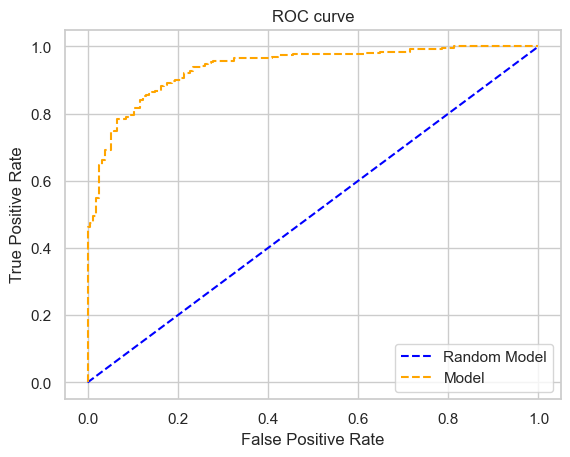

In [27]:
plot_roc_curve(y_true, y_prob)

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- Above plot is used to judge the performance of the model and compare it with plots of other models

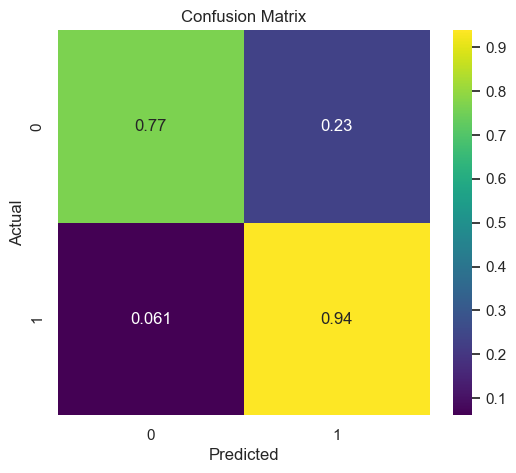

In [28]:
plot_confusion_matrix(y_true, y_pred)

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- 77% of the actual negative cases (class 0, i.e., drivers who did not churn) were correctly predicted by the model as not having churned.
- 23% of the actual negative cases (class 0) were incorrectly predicted by the model as having churned (false alarms).
- 6.1% of the actual positive cases (class 1, i.e., drivers who did churn) were incorrectly predicted by the model as not having churned.
- 94% of the actual positive cases (class 1) were correctly predicted by the model as having churned.

### Summary of Model

- The model has high recall for the positive class (churn), correctly identifying 94% of actual churn cases.
- The model's precision could be impacted by the 23% false positive rate, meaning that when the model predicts churn, there is a non-negligible chance that the prediction could be wrong.

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #9C27B0;color: #fff;display: inline-block;'>Insights</b>

Overall, the model seems to be more effective at identifying churn cases (high recall) than avoiding false alarms (moderate precision).

## Gradient Boosting Classifier

**Hyperparameter tuning using Grid Search without Cross Validation**

In [14]:
paramGrid = ParamGridBuilder()

maxDepth_values = np.random.choice(range(3, 10), size=4, replace=False)
# maxBins_values = np.random.choice(range(32, 257), size=5, replace=False)
stepSize_values =[0.1, 0.2]
maxIter_values = [30, 50, 100, 150]
# subsamplingRate_values = [0.8,1.0]

paramGrid = paramGrid.addGrid(gbt.maxDepth, maxDepth_values) \
                    .addGrid(gbt.maxIter, maxIter_values) \
                    .addGrid(gbt.stepSize, stepSize_values) \
                    .build()

In [12]:
%%time
with mlflow.start_run(run_name="Gradient Boosting" ):
    gbt_cv_model, gbt_evaluator = fit_model(gbt, paramGrid, trainingData, use_train_validation_split=True)

    mlflow.log_params({
        "best_maxDepth": gbt_cv_model.bestModel.getMaxDepth(),
        "best_stepSize": gbt_cv_model.bestModel.getStepSize(),
        "best_maxIter": gbt_cv_model.bestModel.getMaxIter(),
    })
    test_predictions = gbt_cv_model.bestModel.transform(testData)

    mlflow.log_metrics({
        "best_f1": gbt_evaluator.evaluate(test_predictions),
        "best_accuracy": gbt_evaluator.setMetricName("accuracy").evaluate(test_predictions),
        "best_precision": gbt_evaluator.setMetricName("weightedPrecision").evaluate(test_predictions),
        "best_recall": gbt_evaluator.setMetricName("weightedRecall").evaluate(test_predictions)
    })

CPU times: user 1.9 s, sys: 937 ms, total: 2.84 s
Wall time: 9min 56s


In [13]:
gbt_best = gbt_cv_model.bestModel
print("MaxDepth:", gbt_best.getMaxDepth(), ", MaxIter:", gbt_best.getMaxIter(), ", StepSize:", gbt_best.getStepSize())

MaxDepth: 4 , MaxIter: 30 , StepSize: 0.2


In [14]:
gbt_best.write().overwrite().save("./model/gbt_model")

In [40]:
gbt_best = GBTClassificationModel.load("./model/gbt_model")
print("MaxDepth:", gbt_best.getMaxDepth(), ", MaxIter:", gbt_best.getMaxIter(), ", StepSize:", gbt_best.getStepSize())

MaxDepth: 6 , MaxIter: 100 , StepSize: 0.1


### Metrics

In [15]:
y_true, y_pred, y_prob = spark_prediction_to_numpy(gbt_best.transform(testData))

**Classification Report**

In [16]:
print_metrics(y_true, y_pred, y_prob)

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       154
           1       0.93      0.87      0.90       263

    accuracy                           0.88       417
   macro avg       0.87      0.88      0.87       417
weighted avg       0.88      0.88      0.88       417

Accuracy:  0.8776978417266187
F1 Score:  0.899803536345776
AUC:  0.9558169966915213


In [17]:
best_threshold= get_best_threshold(y_true, y_prob)

Best threshold: 0.26
Precision at best threshold: 0.9074074074074074
Recall at best threshold: 0.9315589353612167
F1 score at best threshold: 0.9193245778611632


In [26]:
y_pred = (y_prob >= best_threshold).astype(int)

**Best F1 score adjusted Classification Report**

In [27]:
print_metrics(y_true, y_pred, y_prob)

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       154
           1       0.91      0.93      0.92       263

    accuracy                           0.90       417
   macro avg       0.89      0.88      0.89       417
weighted avg       0.90      0.90      0.90       417

Accuracy:  0.8968824940047961
F1 Score:  0.9193245778611632
AUC:  0.9558169966915213


**Feature Importance**

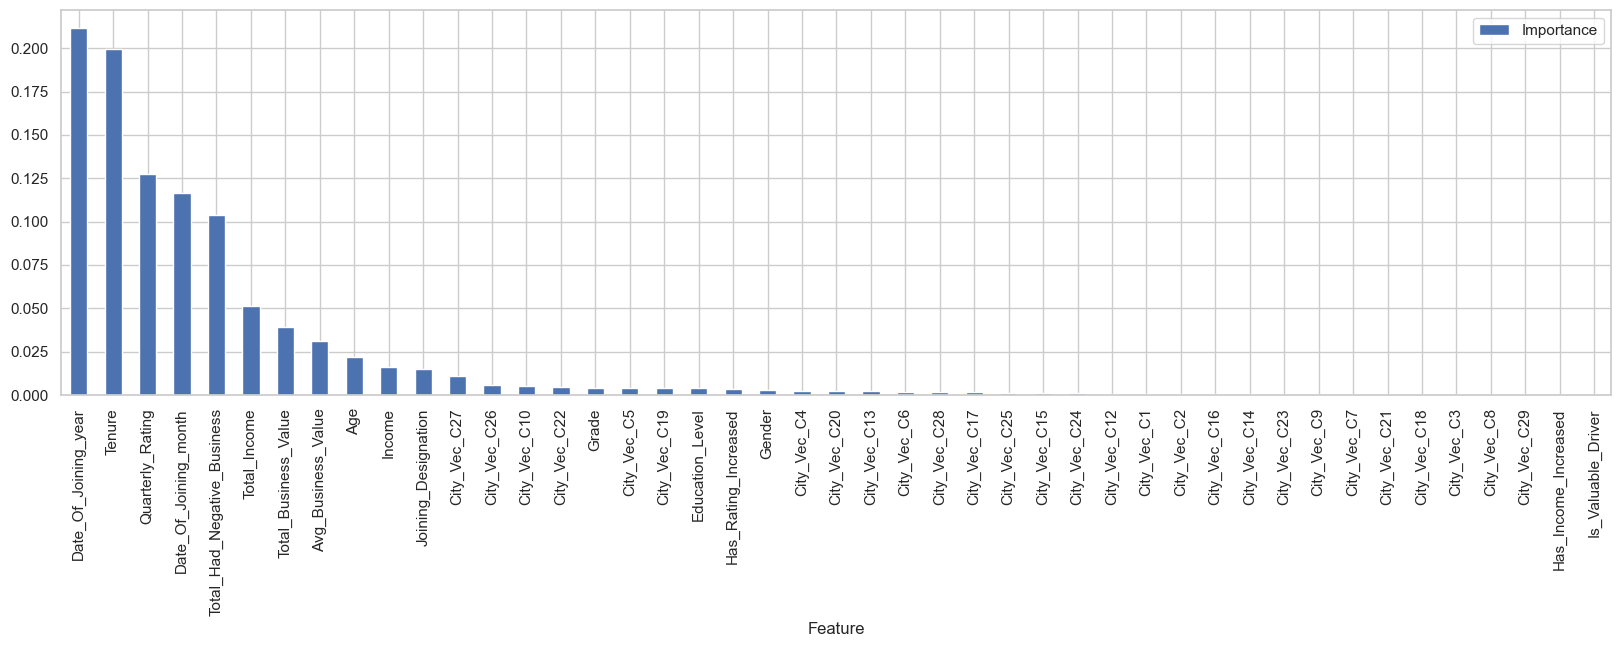

In [25]:
plotfn, _=get_feature_importance(gbt_best, model_df, model_type="pyspark")
plotfn()

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

-  We can see that Joining year is the biggest contributor when deciding on driver churn

**Precision Recall vs Threshold Curve**

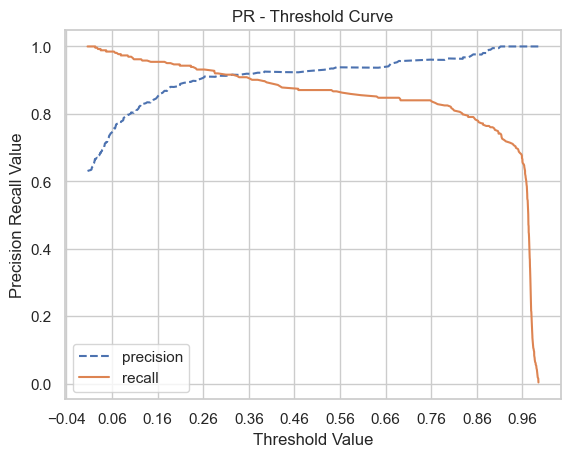

In [29]:
plot_precision_recall_threshold_curve(y_true, y_prob)

**Precision Recall Curve**

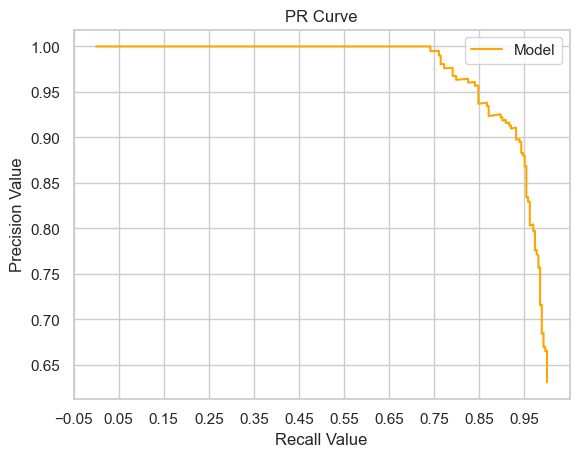

In [28]:
plot_precision_recall_curve(y_true, y_prob)

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above plot we can decide on optimal value of threshold as that can maximize precision or recall as per business needs

**ROC-AUC Curve**

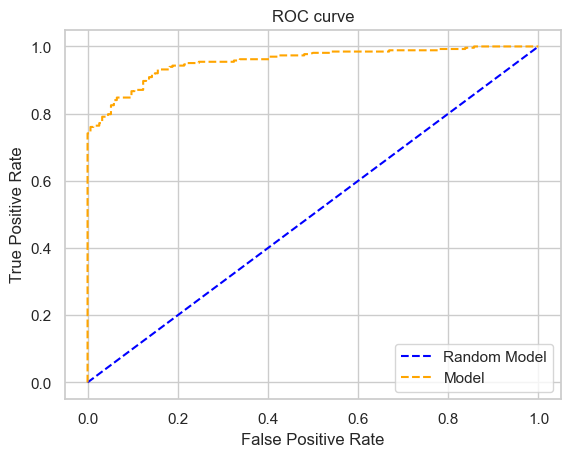

In [30]:
plot_roc_curve(y_true, y_prob)

**Confusion Matrix**

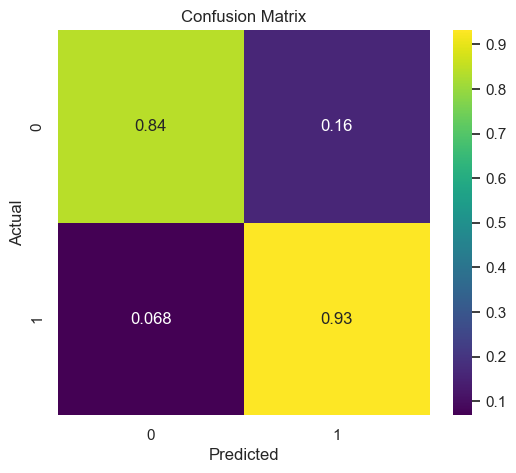

In [31]:
plot_confusion_matrix(y_true, y_pred)

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- 84% of the actual negative cases (class 0, i.e., drivers who did not churn) were correctly predicted by the model as not having churned.
- 16% of the actual negative cases (class 0) were incorrectly predicted by the model as having churned.
- 6.8% of the actual positive cases (class 1, i.e., drivers who did churn) were incorrectly predicted by the model as not having churned.
- 93% of the actual positive cases (class 1) were correctly predicted by the model as having churned.

### Summary
- The model has a high recall for the positive class (churn), correctly identifying 93% of actual churn cases.
- It also has a relatively high precision as indicated by a lower false positive rate (16%).
- True Negative Rate (specificity) is also good, with 84% of non-churn cases correctly identified.

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #9C27B0;color: #fff;display: inline-block;'>Insights</b>

Overall, the model shows strong performance with a good balance between precision and recall, effectively identifying most churn cases while keeping the false positives reasonably low.
This model seems well-tuned, especially for applications where catching potential churners is critical but where it's also important to minimize false positives.

## XGBoost

In [11]:
xgb = SparkXGBClassifier(label_col="Churned", features_col="features", weight_col="classWeightCol", seed=42,  verbose=False)
# xgb_feat = SparkXGBClassifier(label_col="Churned", features_col="features", weight_col="classWeightCol", seed=42, max_depth=5, n_estimators=150, learning_rate=0.1, subsample=0.8)

**Hyperparameter tuning using Cross Validation and GridSearch**

In [12]:
paramGrid = ParamGridBuilder()

maxDepth_values = [3, 5, 7, 10]
# maxBins_values = np.random.choice(range(32, 257), size=5, replace=False)
eta =[0.1, 0.2, 0.3]
num_boosting_rounds_values = [ 150, 200, 250]
subsample_values = [0.8, 1.0]

paramGrid = paramGrid.addGrid(xgb.max_depth, maxDepth_values) \
                    .addGrid(xgb.learning_rate, eta) \
                    .addGrid(xgb.n_estimators, num_boosting_rounds_values) \
                    .addGrid(xgb.subsample, subsample_values) \
                    .build()

In [13]:
with mlflow.start_run(run_name="XGBoost" ):
    xgb_cv_model, xgb_evaluator= fit_model(xgb, paramGrid, trainingData);

    params = {param.name: xgb_cv_model.bestModel.getOrDefault(param) 
              for param in xgb_cv_model.bestModel.extractParamMap()}

    mlflow.log_params({
        "best_maxDepth": params["max_depth"],
        "best_learningRate": params["learning_rate"],
        "best_nEstimators": params["n_estimators"],
        "best_subsample": params["subsample"]
    })
    test_predictions = xgb_cv_model.bestModel.transform(testData)

    mlflow.log_metrics({
        "best_f1": xgb_evaluator.evaluate(test_predictions),
        "best_accuracy": xgb_evaluator.setMetricName("accuracy").evaluate(test_predictions),
        "best_precision": xgb_evaluator.setMetricName("weightedPrecision").evaluate(test_predictions),
        "best_recall": xgb_evaluator.setMetricName("weightedRecall").evaluate(test_predictions)
    })
clear_output()

In [14]:
xgb_best = xgb_cv_model.bestModel
xgb_best.write().overwrite().save("./model/xgb_model")

In [16]:
xgb_best.explainParam("max_depth"), xgb_best.explainParam("learning_rate"), xgb_best.explainParam("n_estimators"), xgb_best.explainParam("subsample")

('max_depth: Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param max_depth (default: None, current: 5)',
 'learning_rate: Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param learning_rate (default: None, current: 0.1)',
 'n_estimators: Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param n_estimators (default: 100, current: 200)',
 'subsample: Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param subsample (default: None, current: 0.8)')

In [38]:
xgb_best = SparkXGBClassifierModel.load("./model/xgb_model")
xgb_best.explainParam("max_depth"), xgb_best.explainParam("learning_rate"), xgb_best.explainParam("n_estimators"), xgb_best.explainParam("subsample")

('max_depth: Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param max_depth (default: None, current: 5)',
 'learning_rate: Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param learning_rate (default: None, current: 0.1)',
 'n_estimators: Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param n_estimators (default: 100, current: 200)',
 'subsample: Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param subsample (default: None, current: 0.8)')

### Metric

In [17]:
test_predictions = xgb_best.transform(testData)

In [18]:
y_true, y_pred, y_prob = spark_prediction_to_numpy(test_predictions)

2024-08-21 12:47:33,187 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


In [19]:
best_threshold= get_best_threshold(y_true, y_prob)

Best threshold: 0.52
Precision at best threshold: 0.9601593625498008
Recall at best threshold: 0.9163498098859315
F1 score at best threshold: 0.9377431906614786


In [20]:
y_pred = (y_prob >= best_threshold).astype(int)

**Best F1 score adjusted Classification Report**

In [21]:
print_metrics(y_true, y_pred, y_prob)

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       154
           1       0.96      0.92      0.94       263

    accuracy                           0.92       417
   macro avg       0.91      0.93      0.92       417
weighted avg       0.93      0.92      0.92       417

Accuracy:  0.9232613908872902
F1 Score:  0.9377431906614786
AUC:  0.9682731716952249


**Feature Importance**

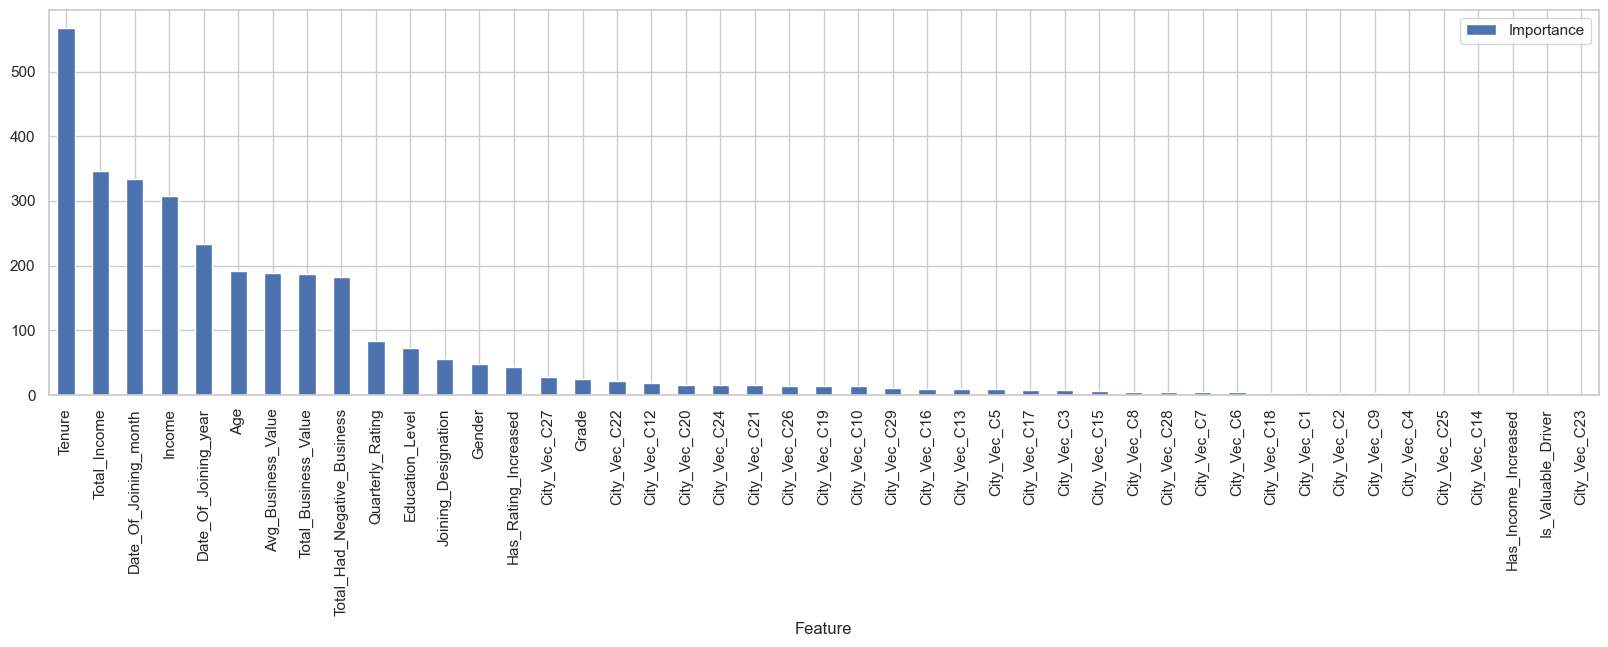

In [22]:
plotfn, _=get_feature_importance(xgb_best, model_df, model_type="xgboost")
plotfn()

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above plot we can see that Tenure is the most important feature

**Precision Recall vs Threshold Curve**

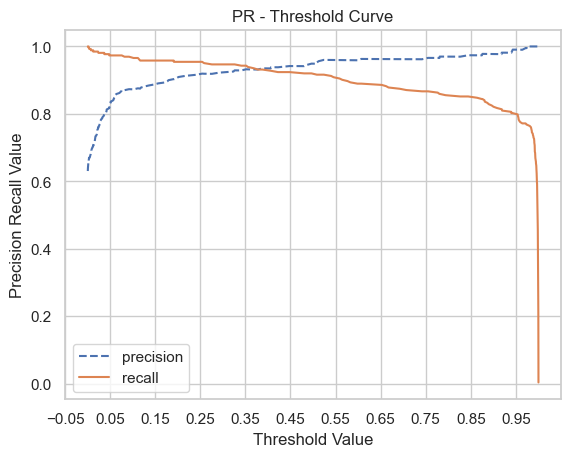

In [47]:
plot_precision_recall_threshold_curve(y_true, y_prob)

**Precision Recall Curve**

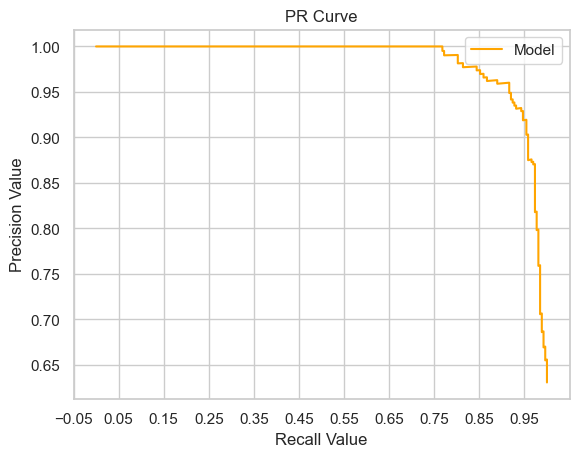

In [46]:
plot_precision_recall_curve(y_true, y_prob)

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above plot we can decide on optimal value of threshold as that can maximize precision or recall as per business needs

**AUC-ROC Curve**

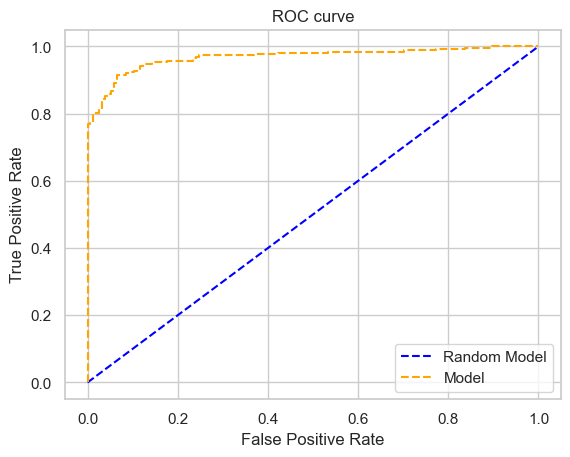

In [48]:
plot_roc_curve(y_true, y_prob)

**Confusion Matrix**

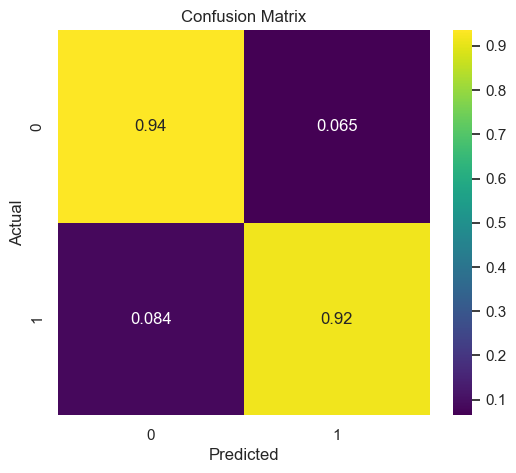

In [49]:
plot_confusion_matrix(y_true, y_pred)

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- 94% of the actual negative cases (class 0, i.e., drivers who did not churn) were correctly predicted by the model as not having churned.
- 6.5% of the actual negative cases (class 0) were incorrectly predicted by the model as having churned.
- 8.4% of the actual positive cases (class 1, i.e., drivers who did churn) were incorrectly predicted by the model as not having churned.
- 92% of the actual positive cases (class 1) were correctly predicted by the model as having churned.

### Summary
- The model has a high true negative rate (specificity), correctly identifying 94% of non-churn cases, which indicates it is very good at avoiding false alarms.
- It also has a high true positive rate (recall) of 92%, correctly identifying most of the churn cases.
- False positive rate is relatively low at 6.5%, meaning the model is effective in minimizing incorrect predictions of churn where there is none.
- False negative rate is 8.4%, so the model misses some churn cases, but overall, the recall is strong.

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #9C27B0;color: #fff;display: inline-block;'>Insights</b>

Overall, this confusion matrix indicates a model that performs well, with strong precision and recall, particularly favoring specificity, making it a good candidate for situations where it is important to correctly identify non-churners while still catching most churners.

## Light GBM

In [15]:
def train_tree(learningRate, numIterations, baggingFraction, tuning=False):
    with mlflow.start_run(nested=True, run_name="LightGBM_default"):

        lgbm = LightGBMClassifier(labelCol="Churned",
                                  featuresCol="features",
                                  weightCol="classWeightCol",
                                  featuresShapCol="shap_values",
                                  seed=42,
                                  learningRate=learningRate,
                                  numIterations=numIterations,
                                  #   maxDepth=maxDepth,
                                  baggingFraction=baggingFraction
                                  )

        if tuning:
            _train = trainingData_v2
            _validation = validationData
        else:
            _train = trainingData
            _validation = testData

        model = lgbm.fit(_train)

        evaluator = MulticlassClassificationEvaluator(
            labelCol="Churned", predictionCol="prediction", metricName="f1", weightCol='classWeightCol')

        predictions = model.transform(_validation)
        f1 = evaluator.evaluate(predictions)
        mlflow.log_params({
            "learningRate": learningRate,
            "numIterations": numIterations,
            # "maxDepth": maxDepth,
            "baggingFraction": baggingFraction
        })
        mlflow.log_metric("f1", f1)
    return model, f1

**Hyperparameter tuning using hyperopt**

In [16]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK


def train_with_hyperopt(params):
    """
    :param params: hyperparameters as a dict. Its structure is consistent with how search space is defined. See below.
    :return: dict with fields 'loss' (scalar loss) and 'status' (success/failure status of run)
    """

    learningRate = params["learningRate"]
    numIterations = params["numIterations"]
    # maxDepth=params["maxDepth"]
    baggingFraction = params["baggingFraction"]

    model, val_metric = train_tree(
        learningRate=learningRate, numIterations=numIterations, baggingFraction=baggingFraction, tuning=True
    )
    loss = -val_metric

    return {"loss": loss, "status": STATUS_OK}


space = {
    "learningRate": hp.uniform("learningRate", 0.1, 0.3),
    "numIterations": hp.uniformint("numIterations", 50, 200),
    # "maxDepth": hp.uniformint("maxDepth", 3, 10),
    "baggingFraction": hp.uniform("baggingFraction", 0.6, 1.0),
}

algo = tpe.suggest

with mlflow.start_run(run_name="Hyperopt_LGBM"):
    best_params = fmin(fn=train_with_hyperopt, space=space,
                       algo=algo, max_evals=30)

clear_output()

In [17]:
best_params

{'baggingFraction': 0.7612915269858092,
 'learningRate': 0.19183342083552588,
 'numIterations': 114.0}

**Hyperparamenter tuning using Optuna**

In [14]:
import optuna
import joblib
from joblibspark import register_spark

register_spark() 
study = optuna.create_study(direction="maximize")

[I 2024-08-21 13:55:48,698] A new study created in memory with name: no-name-3778dcd1-688b-4bc9-ba73-73c1bd7cd750


In [15]:
def objective(trial):

    learningRate = trial.suggest_float("learningRate", 0.1, 0.3)
    numIterations = trial.suggest_int("numIterations", 50, 200)
    baggingFraction = trial.suggest_float("baggingFraction", 0.6, 1.0)

    model, val_metric = train_tree(
        learningRate=learningRate, numIterations=numIterations, baggingFraction=baggingFraction, tuning=True
    )
    return val_metric

In [16]:
with joblib.parallel_backend("spark", n_jobs=-1):
    study.optimize(objective, n_trials=50);
clear_output()

In [19]:
trial = study.best_trial

print(f"Best trial f1 score: {trial.value}")
print("Best trial params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial f1 score: 0.9414124608301843
Best trial params: 
    learningRate: 0.17115815041559626
    numIterations: 164
    baggingFraction: 0.6810831568144191


In [18]:
final_model, metric = train_tree(**best_params, tuning=False)

[LightGBM] [Info] Saving data reference to binary buffer


[LightGBM] [Info] Loaded reference dataset: 45 features, 1964 num_data


In [19]:
metric

0.9285341045543781

In [20]:
final_model.write().overwrite().save("./model/lgbm_model")

**Feature Importance**

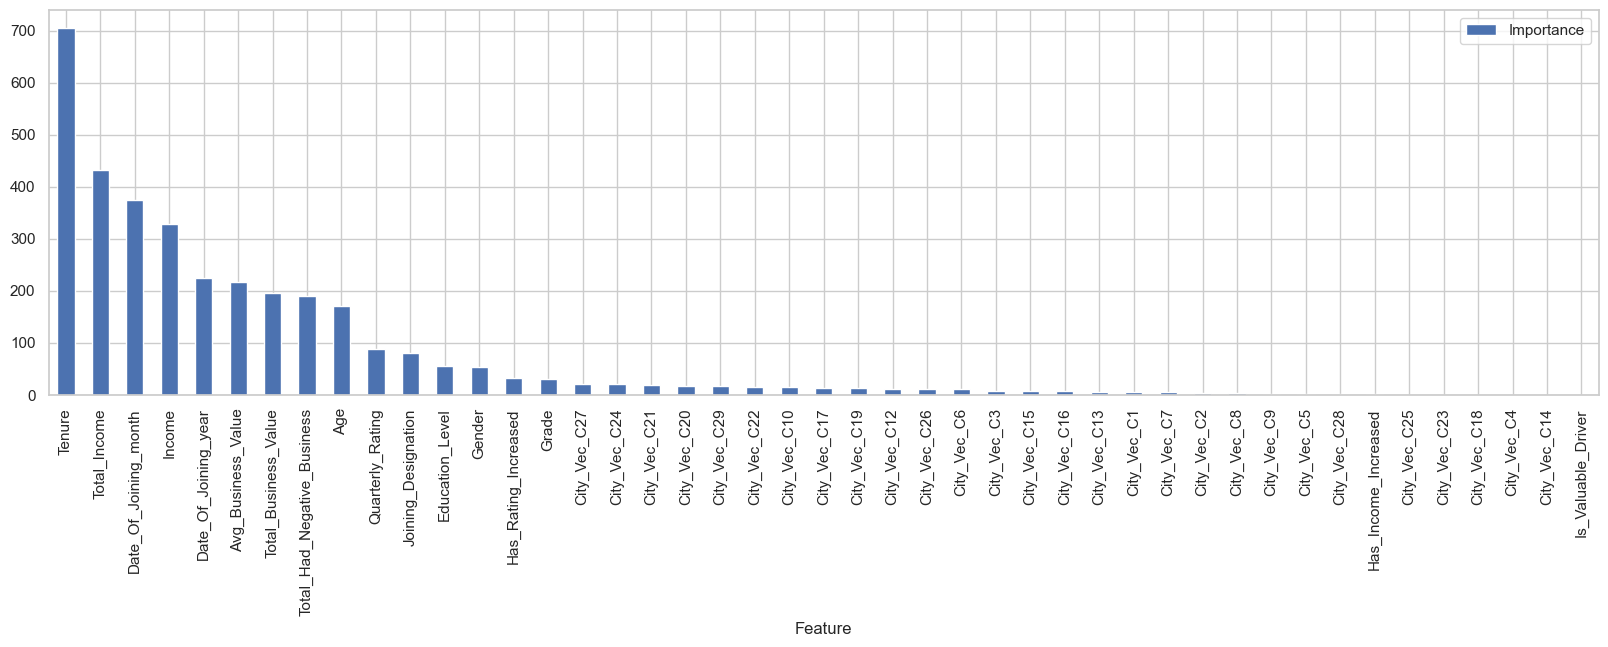

In [21]:
plot_func, _=get_feature_importance(final_model, model_df, model_type="lightgbm")
plot_func();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- We can see that Tenure is the most important feature

### Metrics

In [22]:
test_predictions = final_model.transform(testData)

In [23]:
y_true, y_pred, y_prob = spark_prediction_to_numpy(test_predictions)

**Classification Report**

In [24]:
print_metrics(y_true, y_pred, y_prob)

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       154
           1       0.96      0.91      0.94       263

    accuracy                           0.92       417
   macro avg       0.91      0.93      0.92       417
weighted avg       0.93      0.92      0.92       417

Accuracy:  0.9232613908872902
F1 Score:  0.9375
AUC:  0.9692854673843266


In [25]:
best_threshold = get_best_threshold(y_true=y_true, y_prob=y_prob)

Best threshold: 0.25
Precision at best threshold: 0.9461538461538461
Recall at best threshold: 0.935361216730038
F1 score at best threshold: 0.9407265774378585


In [26]:
y_pred = np.where(y_prob > best_threshold, 1, 0)

**Best F1 score adjusted Classification Report**

In [27]:
print_metrics(y_true, y_pred, y_prob)

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       154
           1       0.95      0.94      0.94       263

    accuracy                           0.93       417
   macro avg       0.92      0.92      0.92       417
weighted avg       0.93      0.93      0.93       417

Accuracy:  0.9256594724220624
F1 Score:  0.9407265774378585
AUC:  0.9692854673843266


**Precision Recall vs Threshold Curve**

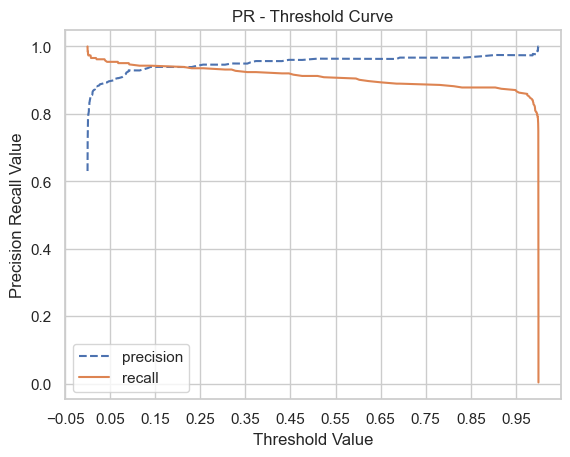

In [28]:
plot_precision_recall_threshold_curve(y_true, y_prob)

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above plot we can decide on optimal value of threshold as that can maximize precision or recall as per business needs

**Precision Recall Curve**

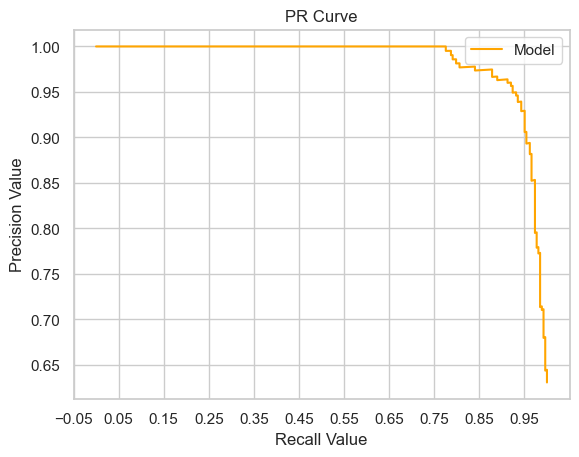

In [29]:
plot_precision_recall_curve(y_true, y_prob)

**ROC-AUC Curve**

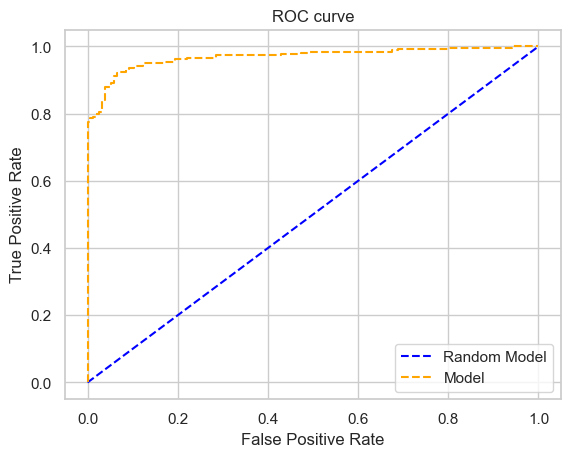

In [30]:
plot_roc_curve(y_true, y_prob)

**Confusion Matrix**

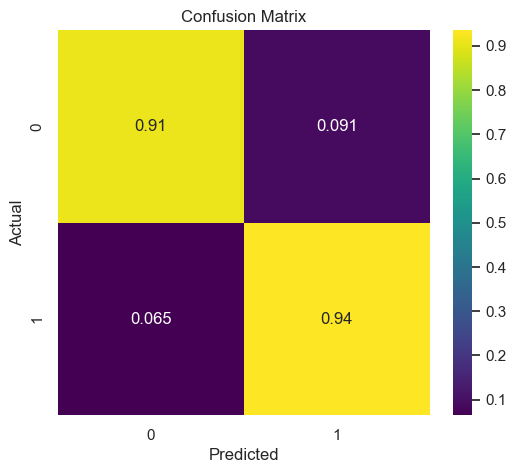

In [31]:
plot_confusion_matrix(y_true, y_pred)

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- The model correctly predicted 91% of the drivers who did not churn (class 0).
- The model incorrectly predicted that 9.1% of the drivers would churn, but they did not.
- The model incorrectly predicted that 6.5% of the drivers would not churn, but they actually did.
- The model correctly predicted 94% of the drivers who churned (class 1).

### Summary

- The model has a high true negative rate (specificity), correctly identifying 91% of non-churn cases, which indicates it is very good at avoiding false alarms.
- It also has a high true positive rate (recall) of 94%, correctly identifying most of the churn cases.
- False positive rate is relatively low at 9.1%, meaning the model is effective in minimizing incorrect predictions of churn where there is none.
- False negative rate is 6.5%, so the model misses some churn cases, but overall, the recall is strong.

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #9C27B0;color: #fff;display: inline-block;'>Insights</b>

Overall, this confusion matrix indicates a model that performs well, with strong precision and recall, particularly favoring recall, making it a good candidate for situations where it is important to correctly identify churners while still maintaining good specificity.

# Model Comparison

In [33]:
best_rf = RandomForestClassificationModel.load("./model/rf_model")
best_gbt = GBTClassificationModel.load("./model/gbt_model")
best_xgb = SparkXGBClassifierModel.load("./model/xgb_model")
best_lgbm = LightGBMClassificationModel.load("./model/lgbm_model")

In [34]:
test_predictions_rf = best_rf.transform(testData)
test_predictions_gbt = best_gbt.transform(testData)
test_predictions_xgb = best_xgb.transform(testData)
test_predictions_lgbm = best_lgbm.transform(testData)

In [35]:
y_true_rf, y_pred_rf, y_prob_rf = spark_prediction_to_numpy(test_predictions_rf)
y_true_gbt, y_pred_gbt, y_prob_gbt = spark_prediction_to_numpy(test_predictions_gbt)
y_true_xgb, y_pred_xgb, y_prob_xgb = spark_prediction_to_numpy(test_predictions_xgb)
y_true_lgbm, y_pred_lgbm, y_prob_lgbm = spark_prediction_to_numpy(test_predictions_lgbm)

2024-08-21 14:27:56,578 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


In [36]:
columns = ["Model", "F1", "Accuracy", "Precision", "Recall", "AUC"]

results = [
    ("Random Forest", f1_score(y_true_rf, y_pred_rf), accuracy_score(y_true_rf, y_pred_rf), precision_score(y_true_rf, y_pred_rf), recall_score(y_true_rf, y_pred_rf), roc_auc_score(y_true_rf, y_prob_rf)),
    ("Gradient Boosting", f1_score(y_true_gbt, y_pred_gbt), accuracy_score(y_true_gbt, y_pred_gbt), precision_score(y_true_gbt, y_pred_gbt), recall_score(y_true_gbt, y_pred_gbt), roc_auc_score(y_true_gbt, y_prob_gbt)),
    ("XGBoost", f1_score(y_true_xgb, y_pred_xgb), accuracy_score(y_true_xgb, y_pred_xgb), precision_score(y_true_xgb, y_pred_xgb), recall_score(y_true_xgb, y_pred_xgb), roc_auc_score(y_true_xgb, y_prob_xgb)),
    ("LightGBM", f1_score(y_true_lgbm, y_pred_lgbm), accuracy_score(y_true_lgbm, y_pred_lgbm), precision_score(y_true_lgbm, y_pred_lgbm), recall_score(y_true_lgbm, y_pred_lgbm), roc_auc_score(y_true_lgbm, y_prob_lgbm))
]

In [37]:
results_df = pd.DataFrame(results, columns=columns).sort_values("F1", ascending=False)
results_df

,Model,F1,Accuracy,Precision,Recall,AUC
3,LightGBM,0.937500,0.923261,0.963855,0.912548,0.969285
2,XGBoost,0.932302,0.916067,0.948819,0.916350,0.968273
1,Gradient Boosting,0.899804,0.877698,0.930894,0.870722,0.955817
0,Random Forest,0.891013,0.863309,0.896154,0.885932,0.936497


<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- We can see that LightGBM has highest F1 score

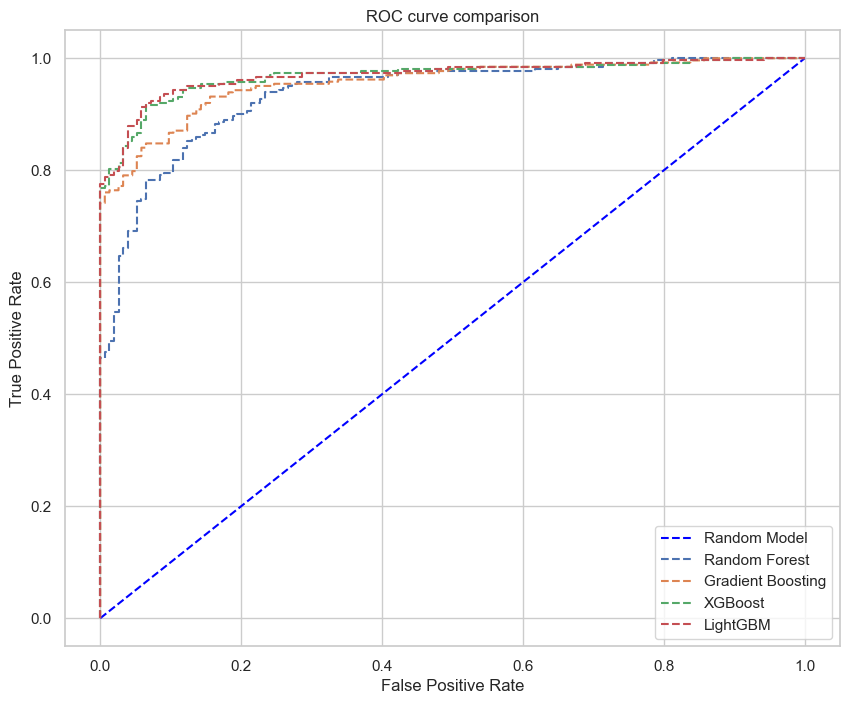

In [38]:
plt.figure(figsize=(10, 8))

plot_roc_curve(y_true_rf, y_prob_rf, label='Random Forest', color=palette[0], show_random=True)
plot_roc_curve(y_true_gbt, y_prob_gbt, label='Gradient Boosting', color=palette[1], show_random=False)
plot_roc_curve(y_true_xgb, y_prob_xgb, label='XGBoost', color=palette[2], show_random=False)
plot_roc_curve(y_true_lgbm, y_prob_lgbm, label='LightGBM', color=palette[3], show_random=False)

# Show the plot
plt.title('ROC curve comparison')
plt.show();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- From above plot we can see that Light Gradient Boosting and XGBoost algorithms has highest area under the curve

<Figure size 1000x800 with 0 Axes>

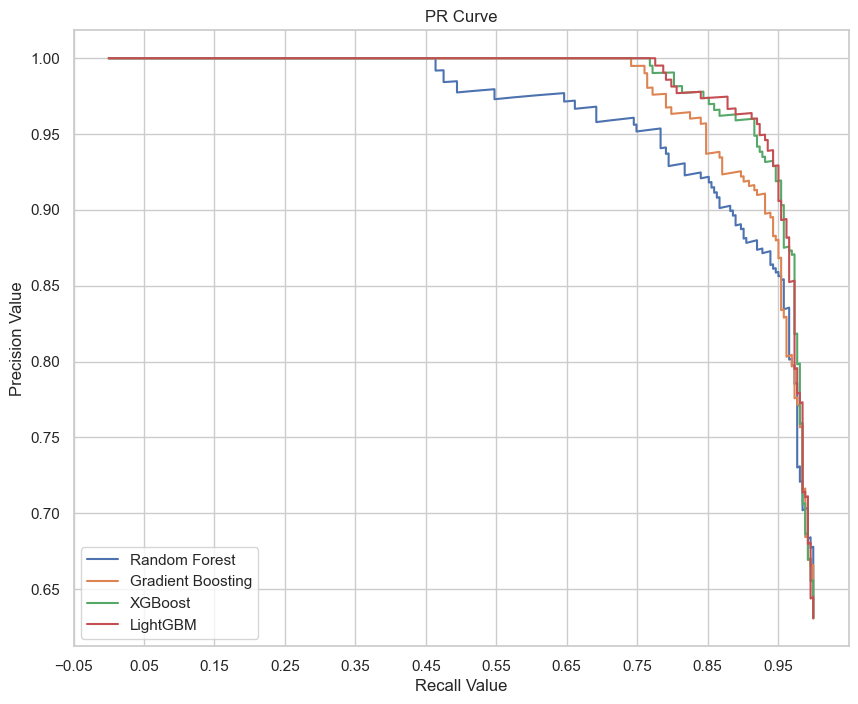

In [39]:
plt.figure(figsize=(10, 8))

plot_precision_recall_curve(y_true_rf, y_prob_rf, label='Random Forest', color=palette[0])
plot_precision_recall_curve(y_true_gbt, y_prob_gbt, label='Gradient Boosting', color=palette[1])
plot_precision_recall_curve(y_true_xgb, y_prob_xgb, label='XGBoost', color=palette[2])
plot_precision_recall_curve(y_true_lgbm, y_prob_lgbm, label='LightGBM', color=palette[3])

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- From above plot we can say that LightGBM has highest area under the curve

# Insights and Recommendations